In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights,
                       early_stopping, reduce_lr, terminate_on_nan)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = False

run2_input = False

omtf_input = False

model_name = 'model12a'

epochs = 200

batch_size = 2048

tile = 4

# ______________________________________________________________________________
if run2_input:
  from nn_encode_run3 import nlayers, nvariables
  from nn_data_run3 import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  infile_muon = infile_muon_run3
  infile_pileup = infile_pileup_run3
  
  model_name = 'model_run3'
  
  epochs = 300
  
  tile = 6

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  infile_muon = infile_muon_omtf
  infile_pileup = infile_pileup_omtf
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 10

In [3]:
#FIXME
learning_rate = 0.0033

### Import data

In [4]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT

test_size = 0.306
if run2_input:
  test_size = 0.304
if omtf_input:
  test_size = 0.311

x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=test_size)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.25.npz ...
[INFO    ] Loaded the variables with shape (3294873, 179)
[INFO    ] Loaded the parameters with shape (3294873, 6)
[INFO    ] Loaded the encoded variables with shape (3294873, 36)
[INFO    ] Loaded the encoded parameters with shape (3294873,)
[INFO    ] Loaded # of training and testing events: (2286641, 1008232)


In [5]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)

test_job = 159

pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test = \
    pileup_data_split(infile_pileup, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_job=test_job)

# Add output nodes for pileup data
if add_noise:
  labels = np.zeros((pu_x_train.shape[0],), dtype=np.float32)
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), labels]
  labels = np.zeros((pu_x_test.shape[0],), dtype=np.float32)
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), labels]

[INFO    ] Loading pileup data from ../test7/histos_tbd.25.npz ...
[INFO    ] Loaded the variables with shape (1135956, 179)
[INFO    ] Loaded the auxiliary PU info with shape (1135956, 4)
[INFO    ] Loaded the encoded variables with shape (1135956, 36)
[INFO    ] Loaded the encoded auxiliary PU info with shape (1135956, 4)
[INFO    ] Loaded # of training and testing events: (936071, 199885)


### Training

In [6]:
from keras import initializers, regularizers, constraints, optimizers, losses
from keras.models import Sequential, Model, clone_model, load_model, model_from_json
from keras.layers import Dense, Activation, Dropout, Input, Concatenate, Lambda, BatchNormalization

from tensorflow.python.ops.distributions import special_math

class _BaseDistribution(object):
  """Abstract base class needed for resolving subclass hierarchy."""
  pass

class Distribution(_BaseDistribution):
  """A generic probability distribution base class."""
  pass

# Truncated Normal probability distribution from tensorflow_probability, copied from:
# (for personal use)
#   https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/distributions/truncated_normal.py
#   https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/distributions/normal.py
#   https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/distributions/distribution.py
#   https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/layers/distribution_layer.py

class TFDTruncatedNormal(Distribution):
  def __init__(self, loc, scale, low, high, name="TruncatedNormal", dtype=tf.float32):
    self._name = name
    self._dtype = dtype
    self._loc = tf.convert_to_tensor(value=loc, name="loc", dtype=dtype)
    self._scale = tf.convert_to_tensor(value=scale, name="scale", dtype=dtype)
    self._low = tf.convert_to_tensor(value=low, name="low", dtype=dtype)
    self._high = tf.convert_to_tensor(value=high, name="high", dtype=dtype)

  @property
  def name(self):
    """Name prepended to all ops created by this `Distribution`."""
    return self._name if hasattr(self, "_name") else None

  @property
  def dtype(self):
    """The `DType` of `Tensor`s handled by this `Distribution`."""
    return self._dtype if hasattr(self, "_dtype") else None

  @property
  def loc(self):
    """Distribution parameter for the mean."""
    return self._loc

  @property
  def scale(self):
    """Distribution parameter for standard deviation."""
    return self._scale

  @property
  def low(self):
    return self._low

  @property
  def high(self):
    return self._high

  @property
  def _standardized_low(self):
    return (self._low - self._loc) / self._scale

  @property
  def _standardized_high(self):
    return (self._high - self._loc) / self._scale

  @property
  def _normalizer(self):
    # norm is in the range [0,1]
    norm = (special_math.ndtr(self._standardized_high) -
            special_math.ndtr(self._standardized_low))
    tiny = np.finfo(self.dtype.as_numpy_dtype).tiny
    eps = np.finfo(self.dtype.as_numpy_dtype).eps
    norm = tf.clip_by_value(norm, tiny, 1 - eps)
    return norm

  def _z(self, x):
    return (x - self.loc) / self.scale

  def _log_prob(self, x):
    res = self._log_unnormalized_prob(x) - self._log_normalization()
    return res

  def _log_unnormalized_prob(self, x):
    return -0.5 * K.square(self._z(x))

  def _log_normalization(self):
    # N = sqrt(2*pi) * sigma * (Phi(beta) - Phi(alpha))
    # np.log(np.sqrt(2.*np.pi)) = 0.5*np.log(2.*np.pi) = 0.9189385332046727
    return 0.5 * np.log(2. * np.pi) + K.log(self.scale) + K.log(self._normalizer)

  def log_prob(self, value, name="log_prob", **kwargs):
    return self._log_prob(value, **kwargs)

  def _log_prob_bkg_pt(self, x, pt):
    reg_pt_scale = tf.constant(100., dtype=x.dtype, name="reg_pt_scale")
    xx = (1.0/pt) * reg_pt_scale
    # If 'loc' is positive, calculate log(1-p) for y = 0. Note that 1-p(x) = p(-x) for normal CDF.
    # If 'loc' is negative, calculate log(p) for y = 1.
    pos_res = special_math.log_ndtr(-self._z(xx))
    neg_res = special_math.log_ndtr(self._z(-xx))
    res = tf.where(self.loc >= 0, pos_res, neg_res)
    #res = tf.where(self.loc >= 0, pos_res, neg_res) - self._log_normalization()
    return res

  def log_prob_bkg_pt25(self, value, name="log_prob_bkg_pt25", **kwargs):
    return self._log_prob_bkg_pt(value, pt=25, **kwargs)

  def log_prob_bkg_pt14(self, value, name="log_prob_bkg_pt14", **kwargs):
    return self._log_prob_bkg_pt(value, pt=14, **kwargs)

  def log_prob_bkg_pt8(self, value, name="log_prob_bkg_pt8", **kwargs):
    return self._log_prob_bkg_pt(value, pt=8, **kwargs)

  def log_prob_bkg_pt5(self, value, name="log_prob_bkg_pt5", **kwargs):
    return self._log_prob_bkg_pt(value, pt=5, **kwargs)

  def _log_prob_sig_pt(self, x, pt):
    reg_pt_scale = tf.constant(100., dtype=x.dtype, name="reg_pt_scale")
    xx = (1.0/pt) * reg_pt_scale
    # If 'loc' is positive, calculate log(p) for y = 1.
    # If 'loc' is negative, calculate log(1-p) for y = 0. Note that 1-p(x) = p(-x) for normal CDF.
    pos_res = special_math.log_ndtr(self._z(xx))
    neg_res = special_math.log_ndtr(-self._z(-xx))
    res = tf.where(self.loc >= 0, pos_res, neg_res)
    #res = tf.where(self.loc >= 0, pos_res, neg_res) - self._log_normalization()
    return res

  def log_prob_sig_pt25(self, value, name="log_prob_sig_pt25", **kwargs):
    return self._log_prob_sig_pt(value, pt=25, **kwargs)

  def log_prob_sig_pt14(self, value, name="log_prob_sig_pt14", **kwargs):
    return self._log_prob_sig_pt(value, pt=14, **kwargs)

  def log_prob_sig_pt8(self, value, name="log_prob_sig_pt8", **kwargs):
    return self._log_prob_sig_pt(value, pt=8, **kwargs)

  def log_prob_sig_pt5(self, value, name="log_prob_sig_pt5", **kwargs):
    return self._log_prob_sig_pt(value, pt=5, **kwargs)

In [7]:
# Loss function
#negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Activation function
def NewElu(x, alpha=1.0, beta=1.0):
  """exponential linear activation: (x+1) if x >= 0 and alpha * exp(x) if x < 0"""
  return K.elu(x * beta, alpha) + alpha*1.0 + 1e-15

def NewIsrlu(x):
  """Inverse square root linear unit: x if x >= 0 and x/sqrt(1+x*x) if x < 0. From arXiv:1811.10276 [hep-ex]."""
  return 1e0 + 5e-3 + tf.where(x >= 0, x, x/tf.sqrt(1e0+tf.square(x)))

# Distribution function
#make_distribution_fn = lambda t: TFDNormal(loc=t[..., :1], scale=K.softplus(t[..., 1:]))  # softplus
#make_distribution_fn = lambda t: TFDNormal(loc=t[..., :1], scale=NewElu(t[..., 1:]))  # elu
#make_distribution_fn = lambda t: TFDNormal(loc=t[..., :1], scale=K.exp(0.5*t[..., 1:]))  # z_log_var

make_distribution_fn = lambda t: TFDTruncatedNormal(loc=t[..., :1], scale=NewElu(t[..., 1:]), low=-0.5*reg_pt_scale, high=+0.5*reg_pt_scale)  # elu

def distribution_loss(y_true, y_pred):
  y = y_true
  rv_y = make_distribution_fn(y_pred)
  return -rv_y.log_prob(y)

def masked_distribution_loss(y_true, y_pred, mask_value=100.):
  y = y_true
  rv_y = make_distribution_fn(y_pred)
  loss = -rv_y.log_prob(y)
  #
  valid = K.not_equal(y, mask_value)
  valid = K.cast(valid, K.floatx())
  loss *= valid
  loss /= (K.mean(valid) + K.epsilon())
  return loss

def unmasked_distribution_loss(y_true, y_pred, mask_value=100.):
  y = y_true
  rv_y = make_distribution_fn(y_pred)
  loss = -rv_y.log_prob(y)
  #
  valid = K.not_equal(y, mask_value)
  valid = K.cast(valid, K.floatx())
  loss *= valid
  loss /= (K.mean(valid) + K.epsilon())
  #
  log_loss = -rv_y.log_prob_bkg_pt5(y)
  log_loss *= (1-valid)
  log_loss /= (K.mean(1-valid) + K.epsilon())
  log_loss_weight = 1.0
  loss += log_loss * log_loss_weight
  return loss

# Build model
def create_model_sequential_tfp(nvariables, lr=0.001, clipnorm=10, nodes1=64, nodes2=32, nodes3=16, 
                                l1_reg=0.0, l2_reg=0.0, act='relu'):
  # Input layer with BN immediately after
  model_seq = Sequential()
  model_seq.add(BatchNormalization(input_shape=(nvariables,), epsilon=1e-5, momentum=0.9))

  # Hidden layers
  if l1_reg == 0 and l2_reg == 0:
    regular = None
  else:
    regular = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)

  model_seq.add(Dense(nodes1, activation=None, kernel_initializer='glorot_uniform', kernel_regularizer=regular, use_bias=False))
  model_seq.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
  model_seq.add(Activation(act))
  if nodes2:
    model_seq.add(Dense(nodes2, activation=None, kernel_initializer='glorot_uniform', kernel_regularizer=regular, use_bias=False))
    model_seq.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
    model_seq.add(Activation(act))
    if nodes3:
      model_seq.add(Dense(nodes3, activation=None, kernel_initializer='glorot_uniform', kernel_regularizer=regular, use_bias=False))
      model_seq.add(BatchNormalization(epsilon=1e-5, momentum=0.9))
      model_seq.add(Activation(act))

  # Output layer
  model_seq.add(Dense(1 + 1, activation=None))

  # Set loss and optimizers
  adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
  #model_seq.compile(optimizer=adam, loss=distribution_loss, metrics=[])
  #model_seq.compile(optimizer=adam, loss=masked_distribution_loss, metrics=[])
  model_seq.compile(optimizer=adam, loss=unmasked_distribution_loss, metrics=[])
  model_seq.summary()
  return model_seq

In [8]:
# Training with Tensorflow Probability Distribution

if do_training:
  assert(keras.backend.backend() == 'tensorflow')

  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, 
                                                   discr_pt_cut=discr_pt_cut, tile=tile)
    #x_train_new, y_train_new = mix_training_inputs_2(x_train, y_train, highpt_x_train, highpt_y_train, pu_x_train, pu_y_train, pu_aux_train, 
    #                                                 discr_pt_cut=discr_pt_cut, tile=tile)
    y_train_new = y_train_new[0]  # ignore PU discr
  else:
    x_train_new = x_train
    y_train_new = y_train

  # Build model
  model_seq = create_model_sequential_tfp(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                                          nodes1=30, nodes2=25, nodes3=20)
  logger.info('Training model with lr: {0} cl: {1} l1_reg: {2} l2_reg: {3}'.format(learning_rate, gradient_clip_norm, l1_reg, l2_reg))

  # Start training
  #callbacks = [lr_decay, terminate_on_nan]
  callbacks = [early_stopping, reduce_lr, terminate_on_nan]
  history = train_model(model_seq, x_train_new, y_train_new,
                        model_name=model_name, epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks, validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), epochs, history.history['loss'][-1], history.history['val_loss'][-1]]
  logger.info('Epoch {0}/{1} - loss: {2} - val_loss: {3}'.format(*metrics))

In [9]:
# Validation

if do_training:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.ylim(1,5)
  plt.show()

### Regression Results

In [10]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, separation_score, find_efficiency_errors, \
                         np_printoptions)

from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error, \
                             roc_curve, roc_auc_score, log_loss)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [11]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name+'.json', weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

#transform_scale = lambda x: np.log(np.exp(x) + 1)  # softplus
transform_scale = lambda x: np.where(x >= 0, (x+1), np.exp(np.clip(x, -np.inf, 0)))  # elu
#transform_scale = lambda x: np.exp(0.5*x)  # z_log_var

# Prepare y_test_true, y_test_pred
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true[:, np.newaxis]
y_test_true /= reg_pt_scale

y_test_pred = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_pred, list):
  y_test_pred = y_test_pred[0]
  y_test_pred /= reg_pt_scale
elif isinstance(y_test_pred, np.ndarray) and y_test_pred.shape[1] == 2:
  y_test_pred_loc = y_test_pred[..., :1].copy()
  y_test_pred_loc /= reg_pt_scale
  y_test_pred_scale_logit = y_test_pred[..., 1:].copy()
  y_test_pred_scale = transform_scale(y_test_pred_scale_logit)
  y_test_pred_scale /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_pred.shape, y_test_pred

In [12]:
# Prepare pu_y_test_true, pu_y_test_pred
pu_y_test_true = np.full((pu_x_test.shape[0], 1), mask_value, dtype=np.float32)
pu_y_test_pred = loaded_model.predict(pu_x_test, batch_size=4096)
if isinstance(pu_y_test_pred, list):
  pu_y_test_pred = pu_y_test_pred[0]
  pu_y_test_pred /= reg_pt_scale
elif isinstance(pu_y_test_pred, np.ndarray) and pu_y_test_pred.shape[1] == 2:
  pu_y_test_pred_loc = pu_y_test_pred[..., :1].copy()
  pu_y_test_pred_loc /= reg_pt_scale
  pu_y_test_pred_scale_logit = pu_y_test_pred[..., 1:].copy()
  pu_y_test_pred_scale = transform_scale(pu_y_test_pred_scale_logit)
  pu_y_test_pred_scale /= reg_pt_scale
#print pu_y_test_true.shape, pu_y_test_true
#print pu_y_test_pred.shape, pu_y_test_pred

[INFO    ] # of entries: 126029, mean: 2.569901e-02, std: 4.102686e-02, mse: 3.888893e-01, mae: 5.534013e-02, mad: 2.528607e-02
[INFO    ] gaus fit (a, mu, sig): 1.000415e+04, 8.051176e-05, 2.142162e-02
[INFO    ] # of entries: 20458, mean: 2.018885e-02, std: 1.467303e-02, mse: 1.793048e-01, mae: 3.189067e-02, mad: 8.433969e-03
[INFO    ] gaus fit (a, mu, sig): 1.627648e+03, -5.209355e-05, 7.188426e-03
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


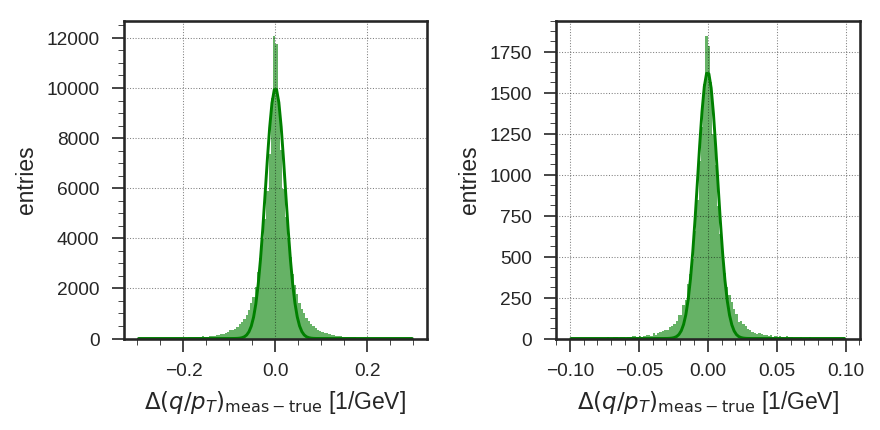

In [13]:
# Plot Delta(q/pT)
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = y_test_true
yb = y_test_pred_loc
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=120, range=(-0.3,0.3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
axs[0].set_ylabel(r'entries')

sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=120, range=(-0.3/3,0.3/3), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3/3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<0.3/3]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
axs[1].set_ylabel(r'entries')

plt.show()

[INFO    ] # of entries: 126029, mean: 9.801862e-02, std: 1.226232e-01, mse: 2.221964e+02, mae: 2.630542e-01, mad: 1.443970e-01
[INFO    ] gaus fit (a, mu, sig): 8.929847e+03, -2.854924e-02, 1.278934e-01
[INFO    ] # of entries: 20458, mean: 6.211818e-01, std: 1.449700e-01, mse: 1.364325e+03, mae: 9.297339e-01, mad: 2.669844e-01
[INFO    ] gaus fit (a, mu, sig): 8.602826e+02, -8.363257e-02, 2.012996e-01


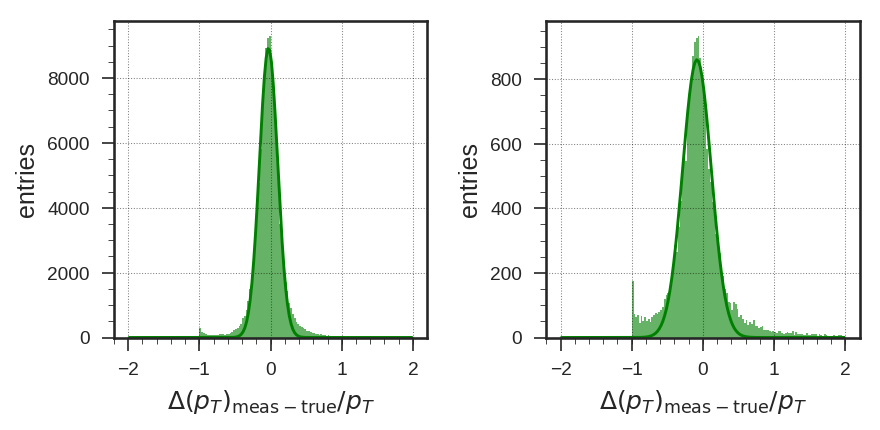

In [14]:
# Plot Delta(q/pT) / pT
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

ya = np.abs(y_test_true/y_test_true)
yb = np.abs(y_test_true/y_test_pred_loc)
yy = yb - ya

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[0].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=12)
axs[0].set_ylabel(r'entries', fontsize=12)

sel = (np.abs(1.0/y_test_true) > discr_pt_cut_high)
ya = ya[sel]
yb = yb[sel]
yy = yy[sel]

mse, mae, mad = mean_squared_error(ya, yb), mean_absolute_error(ya, yb), median_absolute_error(ya, yb)/0.6745  # (y_true, y_pred)
hist, edges, _ = axs[1].hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
logger.info('# of entries: {0}, mean: {1:e}, std: {2:e}, mse: {3:e}, mae: {4:e}, mad: {5:e}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3]), mse, mae, mad))
popt = fit_gaus(hist, edges, mu=0., sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
xdata = (edges[1:] + edges[:-1])/2
axs[1].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[1].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=12)
axs[1].set_ylabel(r'entries', fontsize=12)

plt.show()

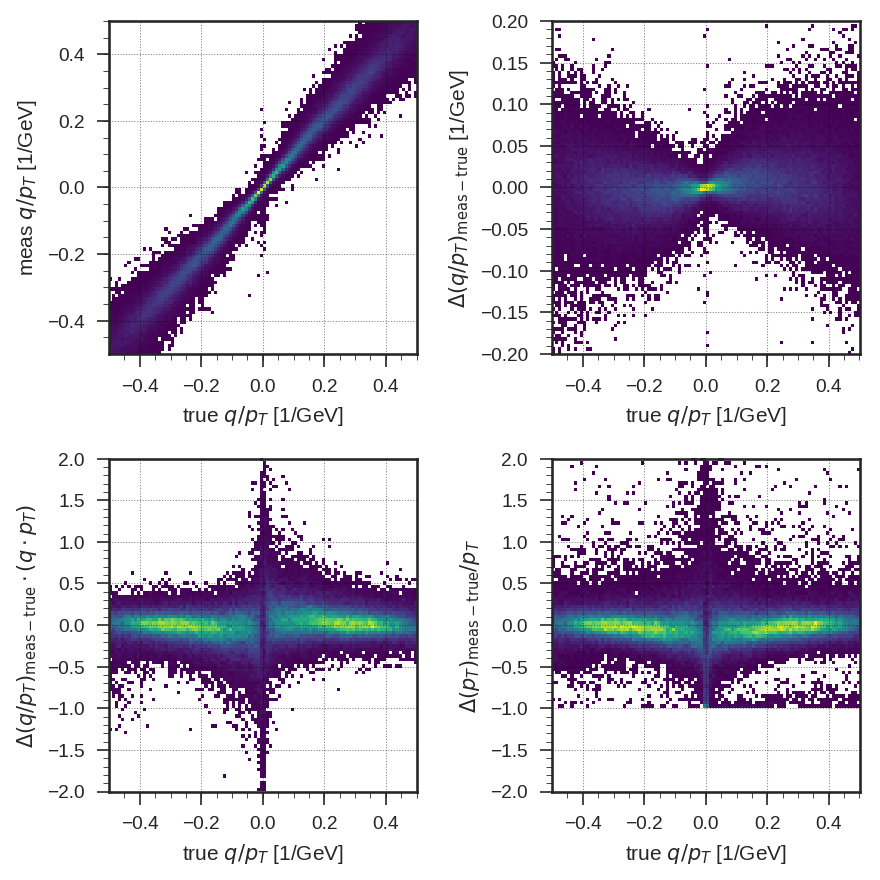

In [15]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred_loc
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_pred_loc - y_test_true
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_pred_loc - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(y_test_true/y_test_pred_loc) - np.abs(y_test_true/y_test_true))
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [16]:
# Make better resolution plot
# resolution defined as delta pT over pT (no charge), binned in 1/pT (also no charge)
xx = np.abs(y_test_true)
yy = (np.abs(y_test_true/y_test_pred_loc) - np.abs(y_test_true/y_test_true))
xx = np.squeeze(xx)
yy = np.squeeze(yy)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
zzz = np.zeros(nbinsx, dtype=np.float32)
ttt = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = hist - ydata
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  hightail = zdata.sum()/len(xx_i)
  #print i, len(xx_i), zdata.sum(), hightail
  
  # Estimate coverage
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  coverage = -1*pct[0]/popt[2]
  
  if 14. < pt < 15.:
    ind_14GeV, xx_14GeV, yy_14GeV = i, xx_i, yy_i
  elif 20. < pt < 22.:
    ind_20GeV, xx_20GeV, yy_20GeV = i, xx_i, yy_i
  elif 25. < pt < 28.:
    ind_25GeV, xx_25GeV, yy_25GeV = i, xx_i, yy_i
  
  xxx[i] = pt
  yyy[i] = popt[2]
  zzz[i] = hightail
  ttt[i] = coverage

[INFO    ] gaus fit (a, mu, sig): 7.990087e+01, -5.619026e-02, 1.646537e-01
[INFO    ] gaus fit (a, mu, sig): 7.947440e+01, -6.658890e-02, 1.671807e-01
[INFO    ] gaus fit (a, mu, sig): 7.349910e+01, -8.769289e-02, 1.816977e-01


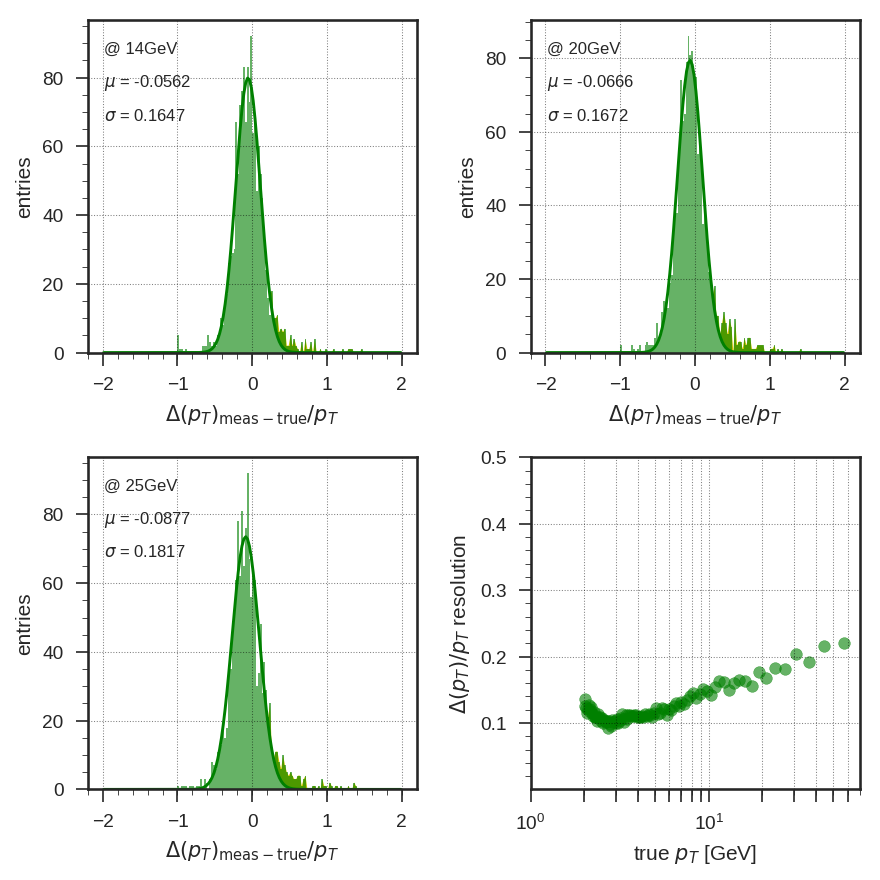

In [17]:
# Make better resolution plot
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

def doit():
  hist, edges, _ = ax.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
  xdata = (edges[1:] + edges[:-1])/2
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  logger.info('gaus fit (a, mu, sig): {0:e}, {1:e}, {2:e}'.format(popt[0], popt[1], popt[2]))
  
  # Estimate high tail
  ydata = gaus(xdata, popt[0], popt[1], popt[2])
  zdata = (hist - ydata)
  zdata[zdata < 0] = 0    # ignore hist < gaus
  zdata[xdata < 0.2] = 0  # ignore low tail
  
  ax.plot(xdata, ydata, color='g')
  ax.fill_between(xdata, ydata, ydata+zdata, facecolor='y')
  ax.text(0.05, 0.9, r'@ %iGeV' % pt, transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=ax.transAxes, fontsize=8)
  ax.text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=ax.transAxes, fontsize=8)
  ax.set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
  ax.set_ylabel(r'entries', fontsize=10)

ax = axs[0,0]
yy = yy_14GeV
pt = 14
doit()

ax = axs[0,1]
yy = yy_20GeV
pt = 20
doit()

ax = axs[1,0]
yy = yy_25GeV
pt = 25
doit()

ax = axs[1,1]
ax.scatter(xxx, yyy, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,0.5)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

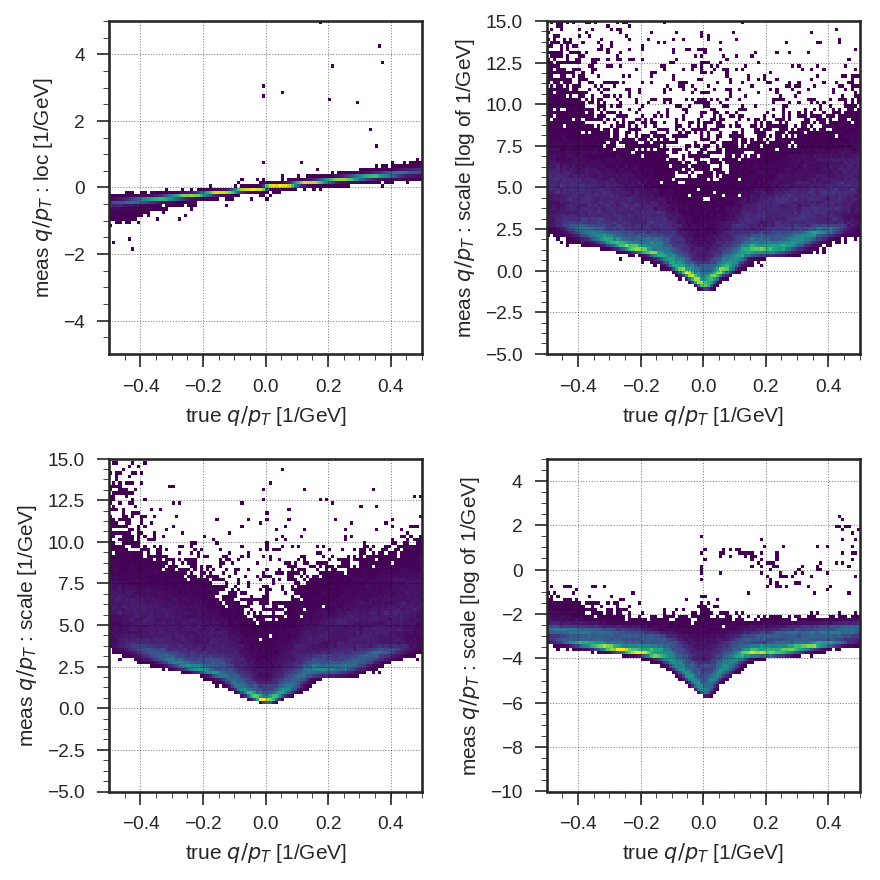

In [18]:
# Check loc, scale
fig, axs = plt.subplots(2, 2, figsize=(6,6), tight_layout=True)

xx = y_test_true
yy = y_test_pred_loc
axs[0,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ : loc [1/GeV]', fontsize=10)

xx = y_test_true
yy = y_test_pred_scale_logit
axs[0,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,15)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'meas $q/p_{T}$ : scale [log of 1/GeV]', fontsize=10)

xx = y_test_true
yy = y_test_pred_scale * reg_pt_scale
#yy = NewElu(y_test_pred_scale_logit).eval(session=sess)
#print yy.min(), yy.max()
axs[1,0].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-5,15)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'meas $q/p_{T}$ : scale [1/GeV]', fontsize=10)

xx = y_test_true
yy = np.log(y_test_pred_scale)
axs[1,1].hist2d(np.squeeze(xx), np.squeeze(yy), bins=(100,100), range=((-0.5,0.5),(-10,5)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'meas $q/p_{T}$ : scale [log of 1/GeV]', fontsize=10)

plt.show()

[INFO    ] high tail prob: 5.355137e-02, 7.042150e-02, 6.966917e-02


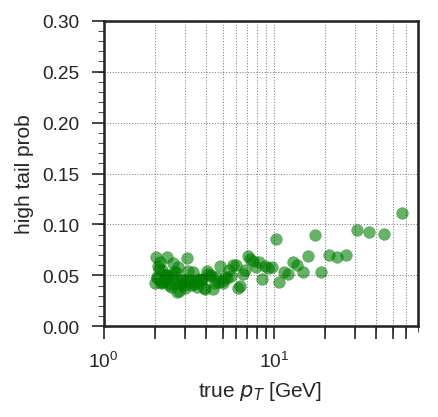

In [19]:
# Estimate high tail that is underestimated by gaus fit
logger.info('high tail prob: {0:e}, {1:e}, {2:e}'.format(zzz[ind_14GeV],zzz[ind_20GeV],zzz[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, zzz, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,0.3)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'high tail prob', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

[INFO    ] coverage # of sigmas: 1.673264e+00, 1.719062e+00, 1.720377e+00


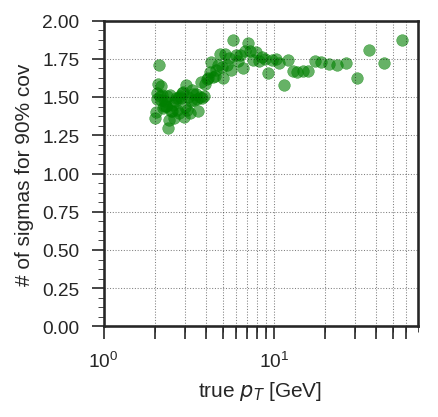

In [20]:
# Estimate coverage, find required number of sigmas for 90% coverage
# If truly gaussian, the required number of sigmas is 1.28155
import scipy.special
#print scipy.special.erfinv(0.80) * np.sqrt(2)
logger.info('coverage # of sigmas: {0:e}, {1:e}, {2:e}'.format(ttt[ind_14GeV],ttt[ind_20GeV],ttt[ind_25GeV]))

fig, ax = plt.subplots(1, 1, figsize=(5.4/2,5.4/2))
ax.scatter(xxx, ttt, color='g', alpha=0.6)
ax.set_xlim(1,70)
ax.set_ylim(0,2)
ax.set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
ax.set_ylabel(r'# of sigmas for 90% cov', fontsize=10)
ax.set_xscale('log')
ax.set_xticks(list(xrange(1,10)) + list(xrange(10,70,10)))
#ax.set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

### Regression Results (2)

[INFO    ] # of entries: 126029, mean: 6.877068e-02, 4.267689e-02, 3.772392e-02, 2.882917e-02, 2.375972e-02, 1.956902e-02


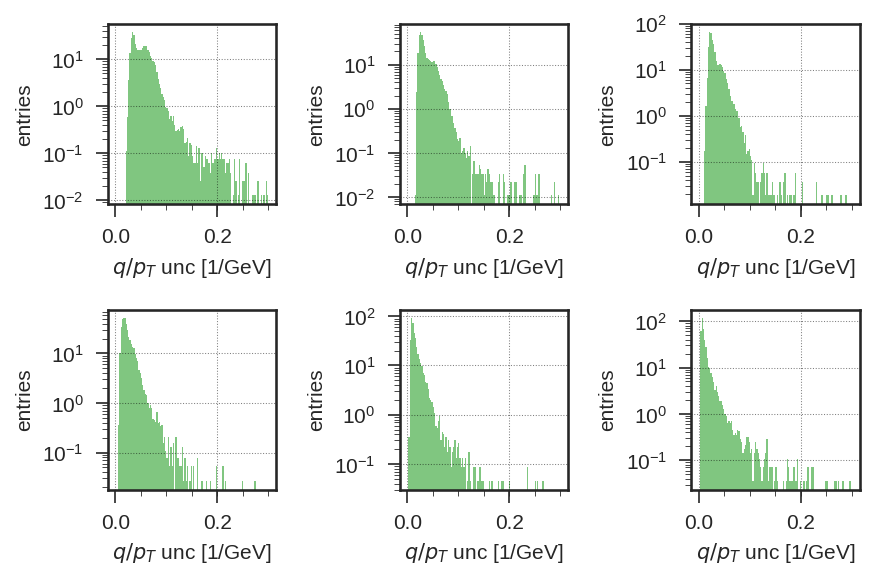

In [21]:
# Plot uncertainties
fig, axs = plt.subplots(2, 3, figsize=(6,4), tight_layout=True)

xx = np.abs(1.0/y_test_true)
yy = y_test_pred_scale
logger.info('# of entries: {0}, mean: {1:e}, {2:e}, {3:e}, {4:e}, {5:e}, {6:e}'.format(len(yy), 
    np.mean(yy[(2<=xx) & (xx<3)]), np.mean(yy[(3<=xx) & (xx<5)]), np.mean(yy[(5<=xx) & (xx<8)]),
    np.mean(yy[(8<=xx) & (xx<14)]), np.mean(yy[(14<=xx) & (xx<25)]), np.mean(yy[(25<=xx) & (xx<np.inf)])))

_kwargs = dict(bins=120, range=(0,0.3), density=True, histtype='stepfilled', facecolor='C2', alpha=0.6)
axs[0,0].hist(yy[(2<=xx) & (xx<3)], **_kwargs)
axs[0,1].hist(yy[(3<=xx) & (xx<5)], **_kwargs)
axs[0,2].hist(yy[(5<=xx) & (xx<8)], **_kwargs)
axs[1,0].hist(yy[(8<=xx) & (xx<14)], **_kwargs)
axs[1,1].hist(yy[(14<=xx) & (xx<25)], **_kwargs)
axs[1,2].hist(yy[(25<=xx) & (xx<np.inf)], **_kwargs)

for ind in np.ndindex(axs.shape):
  ax = axs[ind]
  ax.set_yscale('log')
  ax.set_xlabel(r'$q/p_{T}$ unc [1/GeV]', fontsize=10)
  ax.set_ylabel(r'entries', fontsize=10)
  for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(10)

plt.show()

[INFO    ] # of entries: 199885, mean: 5.736570e-02, 4.094528e-02, 4.135014e-02, 5.042871e-02, 8.453500e-02, 2.055981e-01


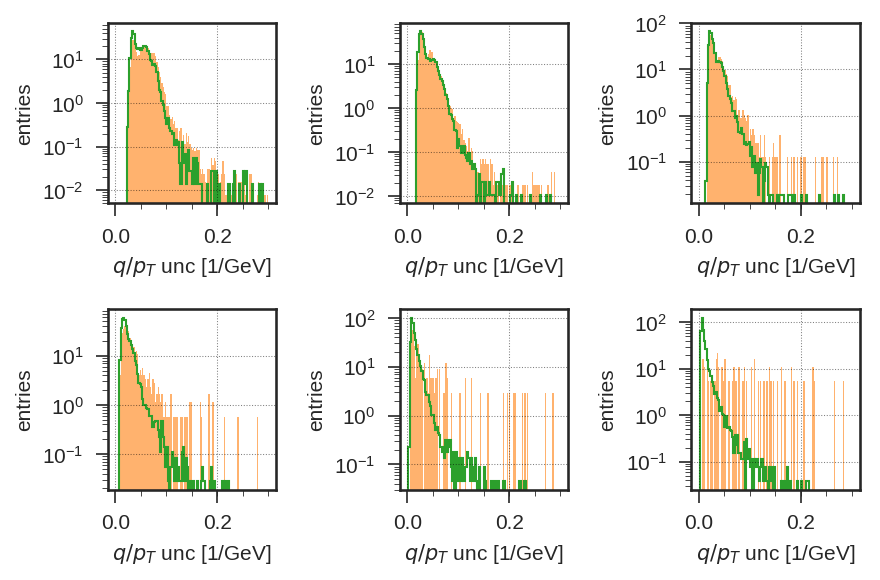

In [22]:
# Plot uncertainties
fig, axs = plt.subplots(2, 3, figsize=(6,4), tight_layout=True)

xx = np.abs(1.0/pu_y_test_pred_loc)
yy = pu_y_test_pred_scale
logger.info('# of entries: {0}, mean: {1:e}, {2:e}, {3:e}, {4:e}, {5:e}, {6:e}'.format(len(yy), 
    np.mean(yy[(2<=xx) & (xx<3)]), np.mean(yy[(3<=xx) & (xx<5)]), np.mean(yy[(5<=xx) & (xx<8)]),
    np.mean(yy[(8<=xx) & (xx<14)]), np.mean(yy[(14<=xx) & (xx<25)]), np.mean(yy[(25<=xx) & (xx<np.inf)])))

_kwargs = dict(bins=120, range=(0,0.3), density=True, histtype='stepfilled', facecolor='C1', alpha=0.6)
axs[0,0].hist(yy[(2<=xx) & (xx<3)], **_kwargs)
axs[0,1].hist(yy[(3<=xx) & (xx<5)], **_kwargs)
axs[0,2].hist(yy[(5<=xx) & (xx<8)], **_kwargs)
axs[1,0].hist(yy[(8<=xx) & (xx<14)], **_kwargs)
axs[1,1].hist(yy[(14<=xx) & (xx<25)], **_kwargs)
axs[1,2].hist(yy[(25<=xx) & (xx<np.inf)], **_kwargs)

xx = np.abs(1.0/y_test_pred_loc)
yy = y_test_pred_scale
_kwargs = dict(bins=120, range=(0,0.3), density=True, histtype='step', color='C2', linewidth=1)
axs[0,0].hist(yy[(2<=xx) & (xx<3)], **_kwargs)
axs[0,1].hist(yy[(3<=xx) & (xx<5)], **_kwargs)
axs[0,2].hist(yy[(5<=xx) & (xx<8)], **_kwargs)
axs[1,0].hist(yy[(8<=xx) & (xx<14)], **_kwargs)
axs[1,1].hist(yy[(14<=xx) & (xx<25)], **_kwargs)
axs[1,2].hist(yy[(25<=xx) & (xx<np.inf)], **_kwargs)

for ind in np.ndindex(axs.shape):
  ax = axs[ind]
  ax.set_yscale('log')
  ax.set_xlabel(r'$q/p_{T}$ unc [1/GeV]', fontsize=10)
  ax.set_ylabel(r'entries', fontsize=10)
  for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(10)

plt.show()

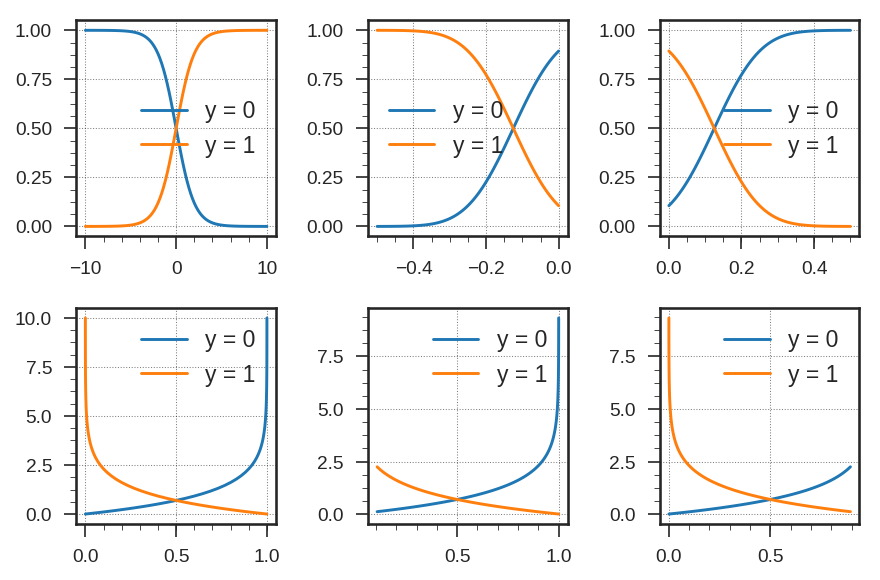

In [23]:
# Mimic sigmoid
fig, axs = plt.subplots(2, 3, figsize=(6,4), tight_layout=True)

logits = np.linspace(-10, 10, 101)
sigmoid_y1 = 1./(1+np.exp(-logits)) # p
sigmoid_y0 = 1 - sigmoid_y1         # 1-p
log_prob_y1 = np.log(sigmoid_y1)
log_prob_y0 = np.log(sigmoid_y0)
axs[0,0].plot(logits, sigmoid_y0, label="y = 0")
axs[0,0].plot(logits, sigmoid_y1, label="y = 1")
axs[0,0].legend()
axs[1,0].plot(sigmoid_y1, -log_prob_y0, label="y = 0")
axs[1,0].plot(sigmoid_y1, -log_prob_y1, label="y = 1")
axs[1,0].legend()

loc = np.linspace(-0.5, 0, 101)
scale = np.ones_like(loc) * 0.1
sigmoid_y1 = (-1./discr_pt_cut - loc)/scale
sigmoid_y1 = 0.5*(1+scipy.special.erf(sigmoid_y1/np.sqrt(2)))  # p
sigmoid_y0 = (-1./discr_pt_cut - loc)/scale
sigmoid_y0 = 0.5*(1+scipy.special.erf(-sigmoid_y0/np.sqrt(2))) # 1-p
log_prob_y1 = np.log(sigmoid_y1)
log_prob_y0 = np.log(sigmoid_y0)
axs[0,1].plot(loc, sigmoid_y0, label="y = 0")
axs[0,1].plot(loc, sigmoid_y1, label="y = 1")
axs[0,1].legend()
axs[1,1].plot(sigmoid_y1, -log_prob_y0, label="y = 0")
axs[1,1].plot(sigmoid_y1, -log_prob_y1, label="y = 1")
axs[1,1].legend()

loc = np.linspace(0, 0.5, 101)
scale = np.ones_like(loc) * 0.1
sigmoid_y1 = (1./discr_pt_cut - loc)/scale
sigmoid_y1 = 0.5*(1+scipy.special.erf(sigmoid_y1/np.sqrt(2)))  # p
sigmoid_y0 = (1./discr_pt_cut - loc)/scale
sigmoid_y0 = 0.5*(1+scipy.special.erf(-sigmoid_y0/np.sqrt(2))) # 1-p
log_prob_y1 = np.log(sigmoid_y1)
log_prob_y0 = np.log(sigmoid_y0)
axs[0,2].plot(loc, sigmoid_y0, label="y = 0")
axs[0,2].plot(loc, sigmoid_y1, label="y = 1")
axs[0,2].legend()
axs[1,2].plot(sigmoid_y1, -log_prob_y0, label="y = 0")
axs[1,2].plot(sigmoid_y1, -log_prob_y1, label="y = 1")
axs[1,2].legend()

plt.show()

In [24]:
# Loss function break down (1)
y = y_test_true * reg_pt_scale
rv_y = make_distribution_fn(y_test_pred)
log_prob, log_unnormalized_prob, log_normalization, log_scale = rv_y.log_prob(y), rv_y._log_unnormalized_prob(y), rv_y._log_normalization(), K.log(rv_y.scale)

sess = K.get_session()
log_prob, log_unnormalized_prob, log_normalization, log_scale = sess.run([log_prob, log_unnormalized_prob, log_normalization, log_scale])
logger.info('-log_prob: {0:e} -log_unnormalized_prob: {1:e} log_normalization: {2:e} log_scale: {3:e}'.format(-np.mean(log_prob), -np.mean(log_unnormalized_prob), +np.mean(log_normalization), +np.mean(log_scale)))

[INFO    ] -log_prob: 2.402751e+00 -log_unnormalized_prob: 4.913425e-01 log_normalization: 1.911408e+00 log_scale: 1.090203e+00


In [25]:
# Loss function break down (2)
pu_y = pu_y_test_true
rv_pu_y = make_distribution_fn(pu_y_test_pred)
log_prob_bkg_pt25 = rv_pu_y.log_prob_bkg_pt25(pu_y)
log_prob_bkg_pt14 = rv_pu_y.log_prob_bkg_pt14(pu_y)
log_prob_bkg_pt8 = rv_pu_y.log_prob_bkg_pt8(pu_y)
log_prob_bkg_pt5 = rv_pu_y.log_prob_bkg_pt5(pu_y)

sess = K.get_session()
log_prob_bkg_pt25, log_prob_bkg_pt14, log_prob_bkg_pt8, log_prob_bkg_pt5 = sess.run([log_prob_bkg_pt25, log_prob_bkg_pt14, log_prob_bkg_pt8, log_prob_bkg_pt5])
logger.info('-log_prob_bkg_pt25: {0:e}, -log_prob_bkg_pt14: {1:e}, -log_prob_bkg_pt8: {2:e}, -log_prob_bkg_pt5: {3:e}'.format(-np.mean(log_prob_bkg_pt25), -np.mean(log_prob_bkg_pt14), -np.mean(log_prob_bkg_pt8), -np.mean(log_prob_bkg_pt5)))

[INFO    ] -log_prob_bkg_pt25: 1.873317e-03, -log_prob_bkg_pt14: 4.600556e-03, -log_prob_bkg_pt8: 2.516207e-02, -log_prob_bkg_pt5: 1.372551e-01


In [26]:
# Loss function break down (3)
y = y_test_true * reg_pt_scale
rv_y = make_distribution_fn(y_test_pred)
log_prob_sig_pt25 = rv_y.log_prob_sig_pt25(y)
log_prob_sig_pt14 = rv_y.log_prob_sig_pt14(y)
log_prob_sig_pt8 = rv_y.log_prob_sig_pt8(y)
log_prob_sig_pt5 = rv_y.log_prob_sig_pt5(y)

sess = K.get_session()
log_prob_sig_pt25, log_prob_sig_pt14, log_prob_sig_pt8, log_prob_sig_pt5 = sess.run([log_prob_sig_pt25, log_prob_sig_pt14, log_prob_sig_pt8, log_prob_sig_pt5])

log_prob_sig_pt25 = log_prob_sig_pt25[np.abs(y) < reg_pt_scale/25]
log_prob_sig_pt14 = log_prob_sig_pt14[np.abs(y) < reg_pt_scale/14]
log_prob_sig_pt8 = log_prob_sig_pt8[np.abs(y) < reg_pt_scale/8]
log_prob_sig_pt5 = log_prob_sig_pt5[np.abs(y) < reg_pt_scale/5]

logger.info('-log_prob_sig_pt25: {0:e}, -log_prob_sig_pt14: {1:e}, -log_prob_sig_pt8: {2:e}, -log_prob_sig_pt5: {3:e}'.format(-np.mean(log_prob_sig_pt25), -np.mean(log_prob_sig_pt14), -np.mean(log_prob_sig_pt8), -np.mean(log_prob_sig_pt5)))

[INFO    ] -log_prob_sig_pt25: 3.443439e-01, -log_prob_sig_pt14: 2.588744e-01, -log_prob_sig_pt8: 2.269051e-01, -log_prob_sig_pt5: 2.016315e-01


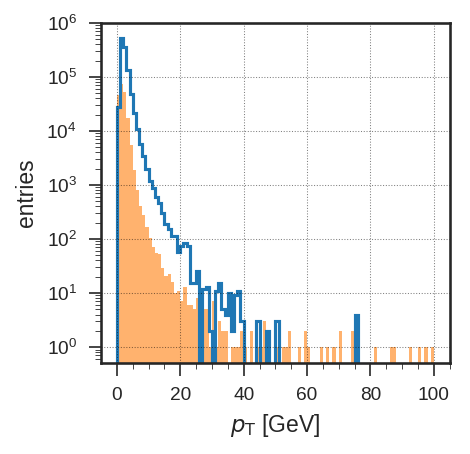

In [27]:
# Minbias spectrum
good_hist = [2.81110e+04, 5.17514e+05, 3.62570e+05, 1.31469e+05, 4.85970e+04, 2.15260e+04,
 1.06050e+04, 5.81200e+03, 3.36800e+03, 1.92800e+03, 1.19700e+03, 8.71000e+02,
 6.02000e+02, 4.58000e+02, 2.99000e+02, 1.92000e+02, 1.55000e+02, 1.14000e+02,
 1.15000e+02, 5.70000e+01, 7.50000e+01, 8.40000e+01, 7.30000e+01, 1.50000e+01,
 1.50000e+01, 2.50000e+01, 0.00000e+00, 1.20000e+01, 1.30000e+01, 2.00000e+00,
 0.00000e+00, 1.10000e+01, 1.50000e+01, 5.00000e+00, 4.00000e+00, 1.00000e+01,
 2.00000e+00, 9.00000e+00, 1.10000e+01, 3.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
 0.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,]

good_hist_edges = np.linspace(0, 100, num=101)
centers = (good_hist_edges[1:] + good_hist_edges[:-1])/2

fig, ax = plt.subplots(1, 1, figsize=(6/2,6/2))
ax.hist(np.abs(1.0/pu_y_test_pred_loc), bins=good_hist_edges, histtype='stepfilled', facecolor='C1', alpha=0.6)
ax.hist(centers, weights=good_hist, bins=good_hist_edges, histtype='step', color='C0', lw=1.5)
ax.set_xlabel(r'$p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'entries')
ax.set_yscale('log')
#ax.set_ylim(1e-1,2e6)
ax.locator_params(axis='x', nbins=6)
plt.show()

### Classification Results

(198091,) (35714,)
(199650,) (20458,)


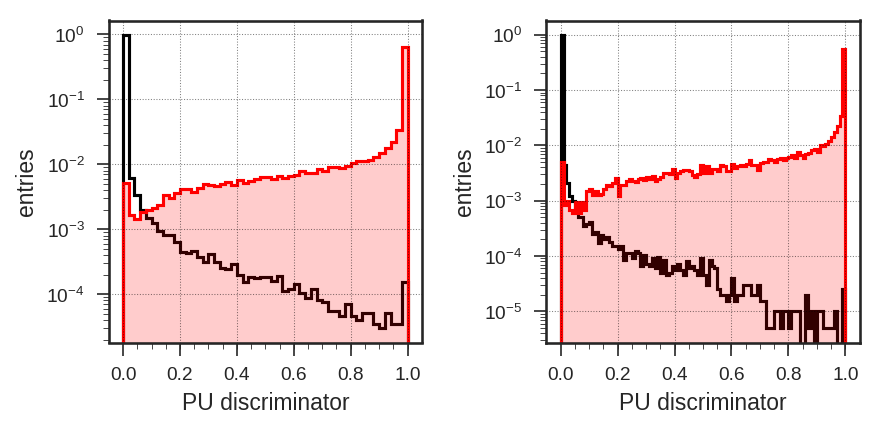

In [28]:
# Plot discriminator
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

def make_sigmoid(loc, scale, discr_pt_cut):
  sigmoid_y0 = (1./discr_pt_cut - loc)/scale
  sigmoid_y0 = 0.5*(1+scipy.special.erf(-sigmoid_y0/np.sqrt(2)))
  sigmoid_y1 = (-1./discr_pt_cut - loc)/scale
  sigmoid_y1 = 0.5*(1+scipy.special.erf(sigmoid_y1/np.sqrt(2)))
  sigmoid = np.where(loc >= 0, sigmoid_y0, sigmoid_y1)
  return (1-sigmoid)

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
y_test_sel = np.abs(1.0/y_test_true) > discr_pt_cut
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_sel = pu_y_test_sel[:, np.newaxis]

y_test_pred_sigmoid = make_sigmoid(y_test_pred_loc, y_test_pred_scale, discr_pt_cut)
pu_y_test_pred_sigmoid = make_sigmoid(pu_y_test_pred_loc, pu_y_test_pred_scale, discr_pt_cut)

yy0 = pu_y_test_pred_sigmoid[pu_y_test_sel]
yy1 = y_test_pred_sigmoid[y_test_sel]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=50, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=50, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=50, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'PU discriminator')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
axs[0].locator_params(axis='x', nbins=6)
print yy0.shape, yy1.shape

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
y_test_sel_high = np.abs(1.0/y_test_true) > discr_pt_cut_high
pu_y_test_sel_high = ~(pu_aux_test[:,2] > discr_pt_cut_high)  # veto PU events with high-pT tracks
pu_y_test_sel_high = pu_y_test_sel_high[:, np.newaxis]

y_test_pred_sigmoid_high = make_sigmoid(y_test_pred_loc, y_test_pred_scale, discr_pt_cut_high)
pu_y_test_pred_sigmoid_high = make_sigmoid(pu_y_test_pred_loc, pu_y_test_pred_scale, discr_pt_cut_high)

yy0 = pu_y_test_pred_sigmoid_high[pu_y_test_sel_high]
yy1 = y_test_pred_sigmoid_high[y_test_sel_high]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[1].hist(yy0, bins=100, range=(0,1), weights=ww0, histtype='step', color='black', lw=1.5)
axs[1].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[1].hist(yy1, bins=100, range=(0,1), weights=ww1, histtype='step', color='red', lw=1.5)
axs[1].set_xlabel(r'PU discriminator')
axs[1].set_ylabel(r'entries')
axs[1].set_yscale('log')
axs[1].locator_params(axis='x', nbins=6)
print yy0.shape, yy1.shape

plt.show()

[INFO    ] auc: 0.901332866004
[INFO    ] thr: [0.7473, 0.6930, 0.6356, 0.5850, 0.5686, 0.5569, 0.5427, 0.5269, 0.5020]
[INFO    ] tpr: [0.9000, 0.9260, 0.9501, 0.9701, 0.9762, 0.9801, 0.9852, 0.9908, 0.9990]
[INFO    ] fpr: [0.3160, 0.4080, 0.5354, 0.6722, 0.7264, 0.7547, 0.8278, 0.8750, 0.9788]
[INFO    ] auc: 0.916324485075
[INFO    ] thr: [0.7148, 0.6663, 0.6160, 0.5678, 0.5604, 0.5472, 0.5368, 0.5230, 0.5029]
[INFO    ] tpr: [0.9003, 0.9258, 0.9502, 0.9717, 0.9753, 0.9812, 0.9852, 0.9905, 0.9991]
[INFO    ] fpr: [0.2400, 0.3657, 0.5029, 0.6229, 0.6400, 0.6743, 0.7714, 0.8914, 0.9600]


(233805,) (233805,) (233805,)
(220108,) (220108,) (220108,)


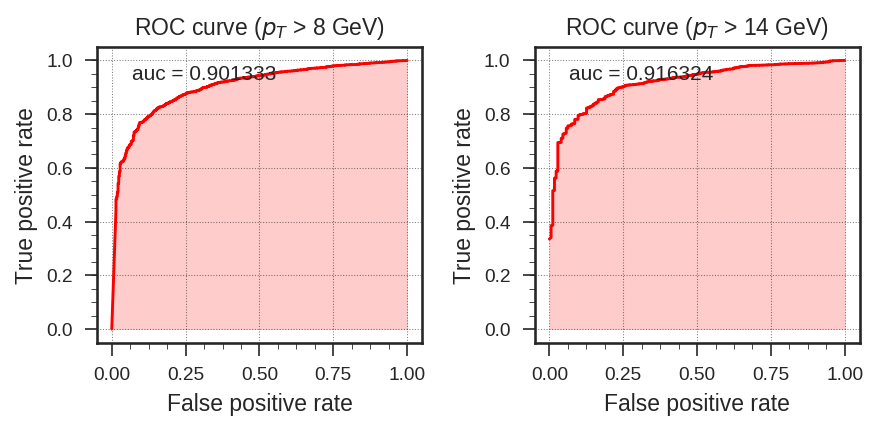

In [29]:
# Plot ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel], np.zeros_like(pu_y_test_true)[pu_y_test_sel]))
yy = np.concatenate((y_test_pred_sigmoid[y_test_sel], pu_y_test_pred_sigmoid[pu_y_test_sel]))
zz = np.concatenate((y_test_pred_loc[y_test_sel], pu_y_test_pred_loc[pu_y_test_sel]))
print xx.shape, yy.shape, zz.shape

zzz = np.abs(1.0/zz) > discr_pt_cut
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[0].plot(fpr, tpr, color='r')
axs[0].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[0].set_title(r'ROC curve ($p_{T}$ > 8 GeV)')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
#axs[0].set_xlim(0.0,0.15)
#axs[0].set_ylim(0.9,1.0)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
xx = np.concatenate((np.ones_like(y_test_true)[y_test_sel_high], np.zeros_like(pu_y_test_true)[pu_y_test_sel_high]))
yy = np.concatenate((y_test_pred_sigmoid_high[y_test_sel_high], pu_y_test_pred_sigmoid_high[pu_y_test_sel_high]))
zz = np.concatenate((y_test_pred_loc[y_test_sel_high], pu_y_test_pred_loc[pu_y_test_sel_high]))
print xx.shape, yy.shape, zz.shape

zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_pred)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_pred)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > 14 GeV)')
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
#axs[1].set_xlim(0.0,0.15)
#axs[1].set_ylim(0.9,1.0)

plt.show()

(424,) (32104,)
(175,) (18158,)


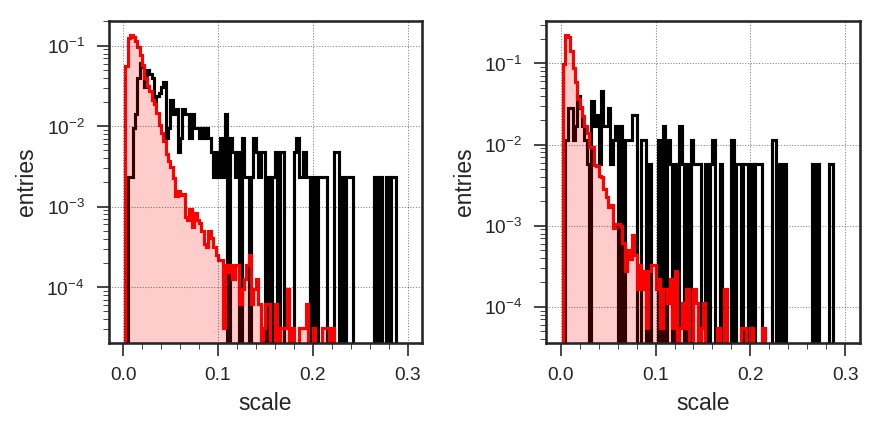

In [30]:
# Plot gaussian scale
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

yy0 = pu_y_test_pred_scale[pu_y_test_sel & (np.abs(1.0/pu_y_test_pred_loc) > discr_pt_cut)]
yy1 = y_test_pred_scale[y_test_sel & (np.abs(1.0/y_test_pred_loc) > discr_pt_cut)]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=120, range=(0,0.3), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=120, range=(0,0.3), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=120, range=(0,0.3), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'scale')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
print yy0.shape, yy1.shape

yy0 = pu_y_test_pred_scale[pu_y_test_sel_high & (np.abs(1.0/pu_y_test_pred_loc) > discr_pt_cut_high)]
yy1 = y_test_pred_scale[y_test_sel_high & (np.abs(1.0/y_test_pred_loc) > discr_pt_cut_high)]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[1].hist(yy0, bins=120, range=(0,0.3), weights=ww0, histtype='step', color='black', lw=1.5)
axs[1].hist(yy1, bins=120, range=(0,0.3), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[1].hist(yy1, bins=120, range=(0,0.3), weights=ww1, histtype='step', color='red', lw=1.5)
axs[1].set_xlabel(r'scale')
axs[1].set_ylabel(r'entries')
axs[1].set_yscale('log')
print yy0.shape, yy1.shape

plt.show()

(424,) (32104,)
(175,) (18158,)


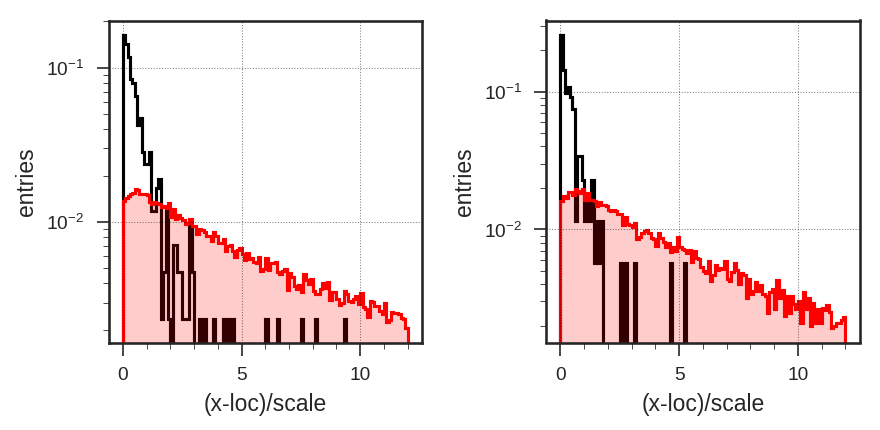

In [31]:
# Plot gaussian (x-loc)/scale
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

yy0 = ((1.0/discr_pt_cut - np.abs(pu_y_test_pred_loc))/pu_y_test_pred_scale)[pu_y_test_sel & (np.abs(1.0/pu_y_test_pred_loc) > discr_pt_cut)]
yy1 = ((1.0/discr_pt_cut - np.abs(y_test_pred_loc))/y_test_pred_scale)[y_test_sel & (np.abs(1.0/y_test_pred_loc) > discr_pt_cut)]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[0].hist(yy0, bins=120, range=(0,12), weights=ww0, histtype='step', color='black', lw=1.5)
axs[0].hist(yy1, bins=120, range=(0,12), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[0].hist(yy1, bins=120, range=(0,12), weights=ww1, histtype='step', color='red', lw=1.5)
axs[0].set_xlabel(r'(x-loc)/scale')
axs[0].set_ylabel(r'entries')
axs[0].set_yscale('log')
print yy0.shape, yy1.shape

yy0 = ((1.0/discr_pt_cut_high - np.abs(pu_y_test_pred_loc))/pu_y_test_pred_scale)[pu_y_test_sel_high & (np.abs(1.0/pu_y_test_pred_loc) > discr_pt_cut_high)]
yy1 = ((1.0/discr_pt_cut_high - np.abs(y_test_pred_loc))/y_test_pred_scale)[y_test_sel_high & (np.abs(1.0/y_test_pred_loc) > discr_pt_cut_high)]
ww0 = np.ones_like(yy0)/float(len(yy0))
ww1 = np.ones_like(yy1)/float(len(yy1))
axs[1].hist(yy0, bins=120, range=(0,12), weights=ww0, histtype='step', color='black', lw=1.5)
axs[1].hist(yy1, bins=120, range=(0,12), weights=ww1, histtype='stepfilled', color='red', alpha=0.2)
axs[1].hist(yy1, bins=120, range=(0,12), weights=ww1, histtype='step', color='red', lw=1.5)
axs[1].set_xlabel(r'(x-loc)/scale')
axs[1].set_ylabel(r'entries')
axs[1].set_yscale('log')
print yy0.shape, yy1.shape

plt.show()

### Efficiency & Rates 

In [32]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

In [33]:
def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)
  return mode

In [34]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8195,  1.5651,  1.6147,  1.8573,  2.2176,  2.6521,  3.1392,  3.6731,
                  4.2603,  4.9059,  5.5810,  6.2768,  6.9787,  7.6670,  8.3289,  8.9703,
                  9.6027, 10.2288, 10.8525, 11.4874, 12.1370, 12.8016, 13.4806, 14.1740,
                 14.8822, 15.5927, 16.3161, 17.0803, 17.8854, 18.6790, 19.4369, 20.1713,
                 20.9279, 21.6733, 22.3966, 23.0878, 23.7421, 24.3612, 24.9927, 25.6638,
                 26.4131, 27.2467, 28.1087, 28.9682, 29.8129, 30.6270, 31.4258, 32.2671,
                 33.1881, 34.2942, 35.4266, 36.4711, 37.5020, 38.4437, 39.2068, 39.8264,
                 40.3814, 40.9442, 41.5449, 42.1736, 42.7892, 43.4046, 44.0388, 44.7361,
                 45.5805, 46.6375, 47.7231, 48.6278, 49.3952, 50.1290, 50.8860, 51.6510,
                 52.4043, 53.1551, 53.9053, 54.6554, 55.4054, 56.1554, 56.9053, 57.6552,
                 58.4051, 59.1550, 59.9048, 60.6547, 61.4045, 62.1544, 62.9042, 63.6540,
                 64.4039, 65.1537, 65.9036, 66.6534, 67.4032, 68.1531, 68.9029, 69.6527,
                 70.4026, 71.1524, 71.9022, 72.6521, 73.4019, 74.1517, 74.9016, 75.6514,
                 76.4012, 77.1511, 77.9009, 78.6507, 79.4006, 80.1504, 80.9002, 81.6501,
                 82.3999, 83.1497, 83.8996, 84.6494, 85.3992, 86.1491, 86.8989, 87.6488]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, x, y_pred):
    xml_pt = np.abs(1.0/y_pred)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return binx.astype(np.int32)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if binx == self.s_nbins-1:  # check boundary
      binx -= 1

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, ndof, mode, strg, zone, theta_median, y_pred, y_scale):
    ipt1 = strg
    ipt2 = find_pt_bin(y_pred)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)

    #strg_ok = quality2 <= (quality1+1)

    trigger = (y_scale > 999999.)  # False

    if self.omtf_input:
      if np.abs(1.0/y_pred) > self.discr_pt_cut_high:  # >14 GeV
        trigger = (y_scale < 0.04)
      elif np.abs(1.0/y_pred) > self.discr_pt_cut:  # 8-14 GeV
        trigger = (y_scale < 0.06)
      else:
        trigger = (y_scale < 0.10)
    elif self.run2_input:
      if np.abs(1.0/y_pred) > self.discr_pt_cut_high:  # >14 GeV
        trigger = (y_scale < 0.04)
      elif np.abs(1.0/y_pred) > self.discr_pt_cut:  # 8-14 GeV
        trigger = (y_scale < 0.06)
      else:
        trigger = (y_scale < 0.10)
    else:
      if np.abs(1.0/y_pred) > self.discr_pt_cut_high:  # >14 GeV
        #trigger = (y_scale < 0.04)
        trigger = (y_scale < 0.10)
        #trigger = ((1.0/14 - np.abs(y_pred))/y_scale) > 0.1
      elif np.abs(1.0/y_pred) > self.discr_pt_cut:  # 8-14 GeV
        #trigger = (y_scale < 0.06)
        trigger = (y_scale < 0.10)
        #trigger = ((1.0/8 - np.abs(y_pred))/y_scale) > 0.1
      else:
        trigger = (y_scale < 0.10)
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (3,))

      y_pred = np.asscalar(y[0,0])
      y_scale = np.asscalar(y[0,1])
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      strg, zone, theta_median = x_road

      passed = self.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_scale)
      xml_pt = np.abs(1.0/y_pred)
      pt = self.get_trigger_pt(x, y_pred)

      if passed:
        trk_q = np.sign(y_pred)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = theta_median
        trk = Track(myroad.id, myroad.hits, mode, zone, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_scale)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [35]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_pred, y_scale, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_pred_loc, y_test_pred_scale, y_test_true)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_scale)
  xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(x, y_pred)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_scale), float(pt_true), float(xml_pt), float(pt), passed
  
eff_data = np.asarray(eff_data)

0 8 0.0481552369893 4.08538961411 4.41148281097 4.79160660553 [ True]
1 5 0.0504927262664 6.72694921494 4.05268669128 4.32832905579 [ True]
2 7 0.0359591692686 5.53976392746 5.67143774033 6.51746429987 [ True]
3 8 0.0302956439555 3.37454724312 4.18509864807 4.49929937439 [ True]
4 6 0.0363690331578 3.06846284866 2.77115249634 2.91625676193 [ True]
5 7 0.0162503011525 9.90972900391 8.52294635773 10.2574232866 [ True]
6 5 0.0572152808309 2.49400019646 2.75761413574 2.90306769104 [ True]
7 8 0.0277999788523 3.99487781525 7.81401777267 9.36746967888 [ True]
8 6 0.0132511556149 16.0083675385 15.0945081711 19.5757136017 [ True]
9 5 0.0226032976061 40.842086792 41.4271507263 60.5454406593 [ True]
10 8 0.0260010845959 3.86498761177 3.63440752029 3.83094819183 [ True]
11 3 0.0415300317109 2.34332799911 2.34413957596 2.51665729151 [ True]
12 4 0.0595449097455 12.8924207687 6.61150550842 7.81461099205 [ True]
13 7 0.00431117974222 21.0111465454 29.4680595398 42.1334380653 [ True]
14 8 0.013957931

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


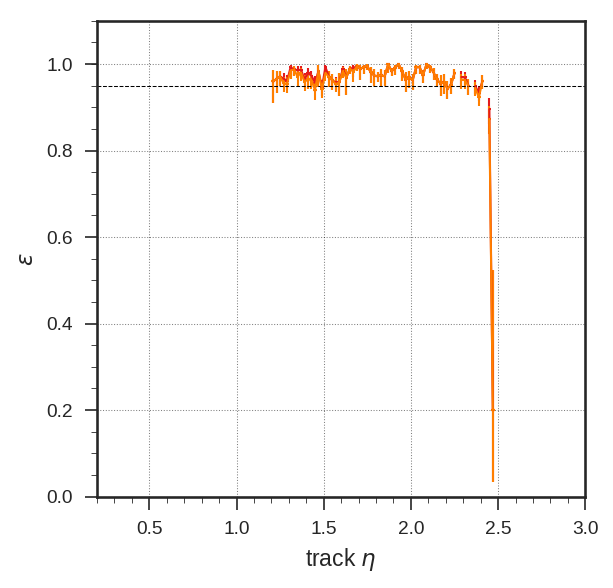

In [36]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is pt_true
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))  

# Efficiency for (L1 pT > 20) only
color = my_palette[1]
passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

# Efficiency for (L1 pT > 20 only && passed)
color = my_palette[3]
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)
  
plt.plot([xlow-0.5,xup+0.5], [0.95,0.95], ls='dashed', lw=0.5, color='black')
plt.xlim(xlow-0.5,xup+0.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


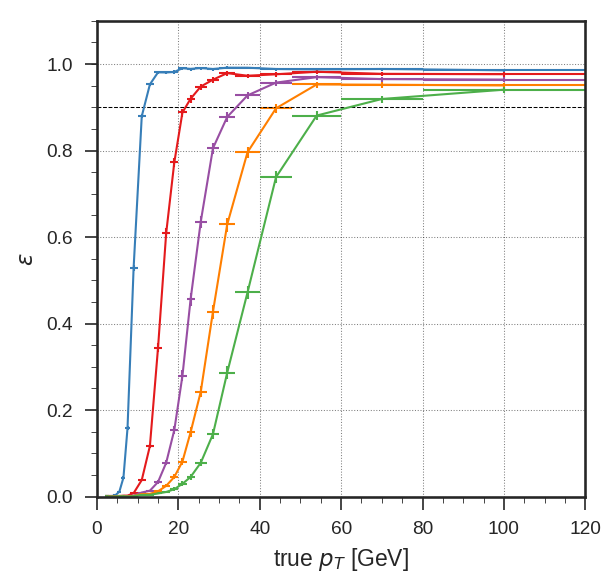

In [37]:
# Efficiency vs pT
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50.)

plt.figure()

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
  eff_hist = np.true_divide(num_hist, denom_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  #print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [38]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((5,nbinsx), dtype=np.float32)

for j in xrange(5):  # j = zone0-1, zone2-4, zone5, zone6, all zones
  if j == 0:
    eff_data_tmp = np.logical_or(eff_data[:,0]==0, eff_data[:,0]==1)
  elif j == 1:
    eff_data_tmp = np.logical_or(eff_data[:,0]==2, eff_data[:,0]==3, eff_data[:,0]==4)
  elif j == 2:
    eff_data_tmp = (eff_data[:,0]==5)
  elif j == 3:
    eff_data_tmp = (eff_data[:,0]==6)
  elif j == 4:
    eff_data_tmp = (eff_data[:,0]>=0)
  
  xx = eff_data[:,1][eff_data_tmp]  # pt_true
  yy = eff_data[:,2][eff_data_tmp]  # xml_pt
  zz = eff_data[:,4][eff_data_tmp]  # discr_passed
  
  ind = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 4:  # ignore below 4 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90  
    coverage += 1.0 # inefficiency due to fiducial cuts
    #coverage += 1.5 # inefficiency due to fiducial cuts
    #pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue
    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    
    xxx[j,i] = pct
    
    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

14.0 0.937601034594
14.5 0.924974306269
15.0 0.866113316492
15.5 0.762195121951
16.0 1.004604437
16.5 0.937081659973
17.0 1.11524163569
17.5 1.13524185587
18.0 1.1452368558
18.5 0.789889415482
19.0 0.885445489762
19.5 0.653206650831
20.0 0.492610837438
20.5 0.514800514801
21.0 0.674763832659
21.5 0.696378830084
22.0 0.725689404935
22.5 0.841622035195
23.0 0.861393891934
23.5 0.901639344262
24.0 0.848176420696
24.5 0.76377523186
25.0 0.798175598632
25.5 0.782661047562
26.0 0.815047021944
26.5 0.936454849498
27.0 0.969529085873
27.5 0.940665701881
28.0 0.891530460624
28.5 0.854037267081
29.0 0.896495517522
29.5 0.762066045724
30.0 0.711743772242


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

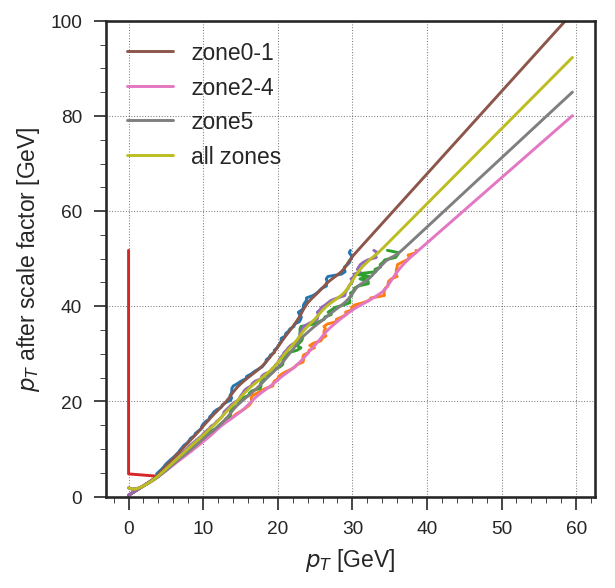

In [39]:
plt.figure()

xdata = (xedges[1:] + xedges[:-1])/2
plt.plot(xxx[0,:-16], xdata[:-16])
plt.plot(xxx[1,:-16], xdata[:-16])
plt.plot(xxx[2,:-16], xdata[:-16])
plt.plot(xxx[3,:-16], xdata[:-16])
plt.plot(xxx[4,:-16], xdata[:-16])
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

xdata = xedges[:-1]
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if not omtf_input:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')
else:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[6:]))

plt.ylim(0,100)
plt.show()

In [40]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, x_road, y_pred, y_scale, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_pred_loc, pu_y_test_pred_scale, pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  strg, zone, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, mode, strg, zone, theta_median, y_pred, y_scale)
  #xml_pt = np.abs(1.0/y_pred)
  pt = mytrigger.get_trigger_pt(x, y_pred)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), 
    print "{0} {1} {2} {3}".format(ndof, pt, y_scale, (1./14 - np.abs(y_pred))/y_scale)
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  31 2826 19.5646 27.5000 7 [23.2445211] [0.0147016] [0.9981313]
  31 2937 11.6057 18.0000 7 [48.71322735] [0.03679675] [1.1312777]
  31 3675  3.0667  8.5000 5 [20.6479718] [0.0493374] [0.16615188]
  31 4581  1.5532     nan 5 [24.0370808] [0.01521163] [1.091185]
  31 4603  2.7349  3.5000 5 [34.63440295] [0.07968628] [0.38728094]
  31 7972  1.3168     nan 4 [40.03463298] [0.07935102] [0.44500148]
  50 6212  1.3540 12.5000 8 [67.62605541] [0.04564362] [1.0901729]
  56 2711 13.1683 21.5000 4 [22.98249209] [0.03394051] [0.41354388]
  56 3501 12.8299 17.5000 6 [20.64448671] [0.07632345] [0.1072841]
  56 5213 12.2996 21.5000 8 [21.64418281] [0.01959611] [0.5486135]
  56 6219  3.7920 10.0000 6 [33.92124399] [0.07598905] [0.39912903]
  56 6292  4.8542  8.5000 4 [23.70324045] [0.04410872] [0.3577799]
  56 7815 12.3604 22.5000 6 [21.02915331] [0.03483532] [0.26389185]
  60 2642 14.2474 26.5000 8 [24.49902746] [0.00896463] [1.9734777]


[INFO    ] nevents: 258400/498400


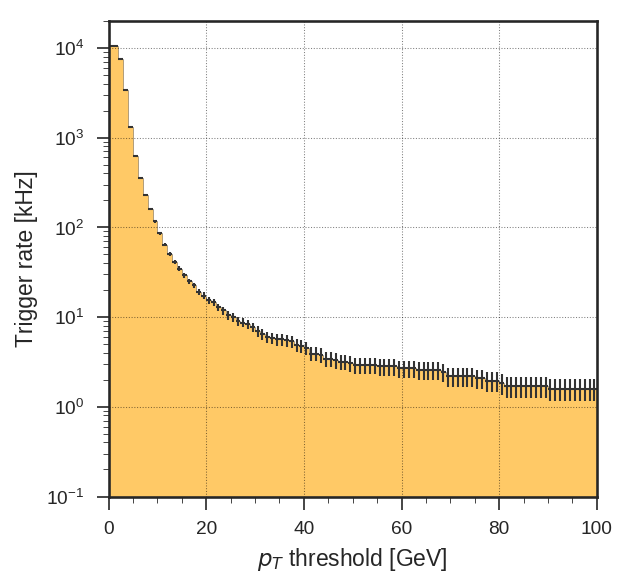

[INFO    ] Rates at 18/19/20/21/22/25 GeV: 19.0645815432, 17.3536575139, 15.52052477, 14.6650627553, 12.8319298923, 9.89891734719


[1.0590e+04, 1.0590e+04, 7.5574e+03, 3.3985e+03, 1.3197e+03, 6.2962e+02,
 3.5832e+02, 2.3012e+02, 1.5948e+02, 1.1647e+02, 8.6402e+01, 6.4037e+01,
 5.0350e+01, 4.1184e+01, 3.4707e+01, 2.9208e+01, 2.5053e+01, 2.2486e+01,
 1.9065e+01, 1.7354e+01, 1.5521e+01, 1.4665e+01, 1.2832e+01, 1.1854e+01,
 1.0510e+01, 9.8989e+00, 9.0435e+00, 8.6768e+00, 8.3102e+00, 7.6992e+00,
 6.9659e+00, 6.4771e+00, 5.9882e+00, 5.8660e+00, 5.6216e+00, 5.6216e+00,
 5.4994e+00, 5.3772e+00, 4.8884e+00, 4.7661e+00, 4.5217e+00, 3.9107e+00,
 3.9107e+00, 3.7885e+00, 3.4218e+00, 3.4218e+00, 3.2996e+00, 3.1774e+00,
 3.1774e+00, 3.0552e+00, 2.9330e+00, 2.9330e+00, 2.9330e+00, 2.9330e+00,
 2.9330e+00, 2.8108e+00, 2.8108e+00, 2.8108e+00, 2.8108e+00, 2.6886e+00,
 2.6886e+00, 2.6886e+00, 2.6886e+00, 2.5664e+00, 2.5664e+00, 2.5664e+00,
 2.5664e+00, 2.5664e+00, 2.4442e+00, 2.1998e+00, 2.1998e+00, 2.1998e+00,
 2.1998e+00, 2.1998e+00, 2.1998e+00, 2.0776e+00, 2.0776e+00, 1.9553e+00,
 1.9553e+00, 1.9553e+00, 1.8331e+00, 1.7109e+00, 1.

In [41]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.show()

logger.info("Rates at 18/19/20/21/22/25 GeV: {0}, {1}, {2}, {3}, {4}, {5}".format(hist[18], hist[19], hist[20], hist[21], hist[22], hist[25]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

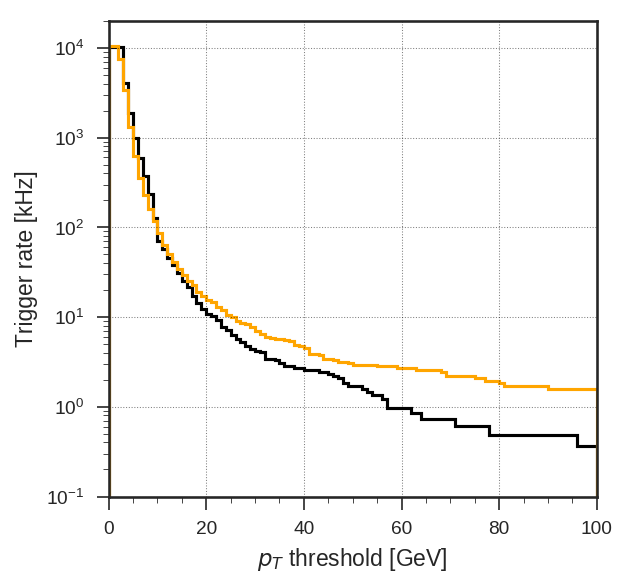

In [42]:
# Old rates
old_hist = [1.0308e+04, 1.0308e+04, 1.0308e+04, 4.0897e+03, 1.8846e+03, 9.9760e+02,
 5.9589e+02, 3.7664e+02, 2.3440e+02, 1.2795e+02, 7.0148e+01, 5.7560e+01,
 4.5217e+01, 3.8007e+01, 3.0797e+01, 2.5542e+01, 2.1509e+01, 1.7354e+01,
 1.4421e+01, 1.2343e+01, 1.0877e+01, 1.0143e+01, 9.2878e+00, 7.8213e+00,
 7.0881e+00, 6.2326e+00, 5.6216e+00, 5.2550e+00, 4.7661e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 3.4218e+00, 3.4218e+00, 3.2996e+00, 3.0552e+00,
 2.8108e+00, 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.5664e+00, 2.5664e+00,
 2.5664e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00, 2.1998e+00, 2.0775e+00,
 1.8331e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.4665e+00,
 1.3443e+00, 1.3443e+00, 1.2221e+00, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 8.5546e-01, 8.5546e-01, 7.3325e-01, 7.3325e-01,
 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,2e4)
plt.yscale('log')
plt.show()

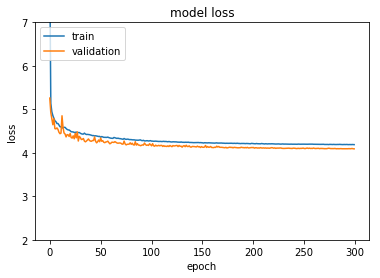

In [43]:
# Training history
# 2019-03-27

"""
[INFO    ] Done training. Time elapsed: 2:07:09.200734 sec
[INFO    ] Epoch 300/300 - loss: 4.18832437807 - regr_loss: 3.69768197815 - discr_loss: 0.0163547465868 - val_loss: 4.091637237 - val_regr_loss: 3.62361362772 - val_discr_loss: 0.015600786963
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3XeYHdV9//H39/at2tVq1QUSIFADJCEERgiDKaEYU2xKYvwz2IaYkGDH5RecxI+Jnzg/x3EIdoKxcYzjgsFEpjk0A0YGgikSSEJCAgmQUNcWbd+99fz+OLNqaIvK3XLv5/U8+9y7986dOTOz+5kzZ86ca845RESk8IUGuwAiIjIwFPgiIkVCgS8iUiQU+CIiRUKBLyJSJBT4IiJFQoEvApjZf5nZP/Zz2vVmds6hzkdkoCnwRUSKhAJfRKRIKPBl2AiaUr5qZm+YWZuZ3W1mY8zscTNrMbOnzax6j+k/ZmarzKzJzBab2fQ93ptjZq+ZWauZ/RpI7LOsj5rZsuCzL5rZCQdZ5uvNbJ2ZNZrZI2Y2PnjdzOzfzGxHUPY3zGxW8N6FZvZmULbNZvaVQ9pwIgEFvgw3HwfOAY4DPgo8AfwtMDr4e74ZH5rHAvcCXwRqgceA35pZzMxiwEPAL4CRwH8H8yX47BzgbuDPgRrgR8AjZhY/kIKa2UeA/wdcCYwDNgD3BW+fB5wBHAuMCKZpCN77CfDnzrkKYBbw+8O5AaV4KfBluPl359x259xm4HngJefc6865LuBBYE4w3VXAo865p5xzaeC7QAlwGnAqEAVud86lnXOLgFf3WMYNwI+ccy8757LOuZ8ByeBzB+KTwN3Oudecc0nga8CHzGwykAYqgGmAOedWO+e2Bp9LAzPMrNI5t9M599ph2nZS5BT4Mtxs3+N5535+Lw+ejw9q1AA453LARmBC8N5mt/fIgRv2eH4k8OWgOafJzJqAScHnDsS+ZWgLavETnHO/B/4DuAPYYWZ3mVllMOnHgQuBDWb2BzP70AEuV2S/FPhSqLYEwQ1Bm3kQ2puBrcCE4LVuR+zxfCPwLedc1R4/pc65ew+xDGVBE9Fm/AHg+865k4AZQdPOV4PXX3XOXRI0Uz0E3H8I20FkFwW+FKr7gYvM7GwziwJfDpplXgT+CGSAm80samaXA/P3+OyPgc+b2SnBxdUyM7vIzCoOsAz3AteZ2eyg/f+fgJedc+vN7ORg/lGgHegCcsE1hk+a2YigKaoFyB3mbSNFSoEvBck59xZwDfDvQD1wMXCxcy7lnEsBlwPXAo1Be/8De3x2CXB90OSyE1gXTHugZXga+Drwm+Cs4mjg6uDtyuDAsjNo9mkA/iV471PAejNrAT4fXAsQOWSmL0ARESkOquGLiBSJvAW+mR0X3LjS/dNiZl/M1/JERKR3A9KkY2bhoGfCKc65Df34iIiIHGYD1aRzNvCOwl5EZPBEBmg5Vwdd1D7AzG4I7mykrKzspGnTph3wzLc0ddLUmWbGuMp+TC0iUjiWLl1a75yr7c+0eW/SCcYt2QLMdM5t723aefPmuSVLlhzwMm59ZBUPvr6Z5d8471CKKiIy7JjZUufcvP5MOxBNOhcAr/UV9ofCDHLqXioi0quBCPw/7ak553AJmaG8FxHpXV4DPxg75Nw972LMh5Bq+CIifcrrRVvnXHswWNRBS6fTbNq0ia6urh6nOXtchlMvGM3q1asPZVFFIZFIMHHiRKLR6GAXRUQG2ED10jlomzZtoqKigsmTJ7P34Ia7bW3upL4txfQJIwa8fMOJc46GhgY2bdrElClTBrs4IjLAhvzQCl1dXdTU1PQY9gA9vyN7MjNqamp6PVsSkcI15AOfIKj6mALUhN8vfW9LESlUwyLw+8Mp8UVEelUQgd9dac3HTWRNTU384Ac/OODPXXjhhTQ1NR328oiIHKyCCPx86inwM5lMr5977LHHqKqqymPJREQOzJDvpTPYbrnlFt555x1mz55NNBolkUhQXV3NmjVrePvtt7n00kvZuHEjXV1dfOELX+CGG24AYPLkySxZsoS2tjYuuOACTj/9dF588UUmTJjAww8/TElJyWCvmogUmWEV+P/w21W8uaXlA6+nszlSmRxl8QNfnRnjK/nGxTN7fP/b3/42K1euZNmyZSxevJiLLrqIlStX7urWePfddzNy5Eg6Ozs5+eST+fjHP05Nzd63Hqxdu5Z7772XH//4x1x55ZX85je/4ZprrjngsoqIHIphFfhDwfz58/fqw/7973+fBx98EICNGzeydu3aDwT+lClTmD17NgAnnXQS69evH+BSi4gMs8DvqSa+o7WLbc1dzBo/glAov90Oy8rKdj1fvHgxTz/9NH/84x8pLS3lzDPP3G8f93g8vut5OByms7Mzr2UUEdmfgrho2x3x+eiYWVFRQWtr637fa25uprq6mtLSUtasWcNLL72UhxKIiBwew6qG37M9I//w1vBrampYsGABs2bNoqSkhDFjxux67/zzz+eHP/wh06dP57jjjuPUU089rMsWETmcBuQ7bftrf1+Asnr1aqZPn97r5+pak2xt7mTG+EoioYI4acmr/mxTERkehtoXoOSd5bNNR0SkQBRE4IuISN8KIvBVwRcR6VtBBL6IiPRNgS8iUiQKIvB3j5Y52CURERm6CiLwh9J3XpWXlwOwZcsWPvGJT+x3mjPPPJN9u5/u6/bbb6ejo2PX7xpuWUQOVYEEfrehU8UfP348ixYtOujP7xv4Gm5ZRA5VQQR+Pnvp3HLLLdxxxx27fr/11lv5x3/8R84++2zmzp3L8ccfz8MPP/yBz61fv55Zs2YB0NnZydVXX8306dO57LLL9hpL58Ybb2TevHnMnDmTb3zjGxAMyLZlyxbOOusszjrrLAiGW66vrwfgtttuY9asWcyaNYvbb7991/KmT5/O9ddfz8yZMznvvPM0Zo+I7GV4Da3w+C2w7Y0PvFyey3FUOkc0Ft7jLqx+Gns8XPDtHt++6qqr+OIXv8hNN90EwP3338+TTz7JzTffTGVlJfX19Zx66ql87GMf6/H7Yu+8805KS0tZvXo1K1asYO7cubve+9a3vsXIkSPJZrOcffbZrFixgptvvpnbbruNZ599llGjRu01r6VLl/LTn/6Ul19+Geccp5xyCh/+8Ieprq7WMMwi0quCquHnw5w5c9ixYwdbtmxh+fLlVFdXM3bsWP72b/+WE044gXPOOYfNmzezffv2Hufx3HPP7QreE044gRNOOGHXe/fffz9z585lzpw5rFq1ijfffLPX8rzwwgtcdtlllJWVUV5ezuWXX87zzz8PGoZZRPowvGr4PdTE2zpSvN/YwbFjKkhEw4d9sVdccQWLFi1i27ZtXHXVVdxzzz3U1dWxdOlSotEokydP3u+wyH157733+O53v8urr75KdXU111577UHNp5uGYRaR3hREDT/frrrqKu677z4WLVrEFVdcQXNzM6NHjyYajfLss8+yYcOGXj9/xhln8Ktf/QqAlStXsmLFCgBaWlooKytjxIgRbN++nccff3zXZ3oalnnhwoU89NBDdHR00N7ezoMPPsjChQsP+zqLSOEZXjX8HuS7U+bMmTNpbW1lwoQJjBs3jk9+8pNcfPHFHH/88cybN49p06b1+vkbb7yR6667junTpzN9+nROOukkAE488UTmzJnDtGnTmDRpEgsWLNj1mRtuuIHzzz+f8ePH8+yzz+56fe7cuVx77bXMnz8fgM997nPMmTNHzTci0qeCGB65uTPFhoYOpo6uoCR2+Jt0Co2GRxYpHEU3PLKGTxMR6VtBBL7iXkSkb8Mi8IdSs9Nwp20pUryGfOAnEgkaGhp6DypV8fvFOUdDQwOJRGKwiyIig2DI99KZOHEimzZtoq6ursdputJZ6ttSuJ1xYpEhfwwbVIlEgokTJw52MURkEAz5wI9Go0yZMqXXaZ5fW8f1v3qFRZ//ECdOHjlgZRMRGU4KojocCsawyalJR0SkR3kNfDOrMrNFZrbGzFab2Yfysxz/mNMFSRGRHuW7Sed7wBPOuU+YWQwozcdCdtfwFfgiIj3JW+Cb2QjgDOBafA+RFJDKx7K6A195LyLSs3w26UwB6oCfmtnrZvafZla270RmdoOZLTGzJb31xOlNSE06IiJ9ymfgR4C5wJ3OuTlAO3DLvhM55+5yzs1zzs2rra09qAWZLtqKiPQpn4G/CdjknHs5+H1RcAA47FTDFxHpW94C3zm3DdhoZscFL50N9P51Tgdpdxu+Al9EpCf57qXzV8A9QQ+dd4Hr8rGQXb10cvmYu4hIYchr4DvnlgH9Gqf5UKgfvohI33SnrYhIkSiMwA/WQm34IiI9K4zAVw1fRKRPBRL4/lFt+CIiPSuIwDeNpSMi0qeCCHyNpSMi0rcCCXz/qBq+iEjPCiTwddFWRKQvBRH4uvFKRKRvBRH4GktHRKRvBRX4atIREelZgQS+f1STjohIzwoi8PUFKCIifSuIwO+u4asNX0SkZwUS+N3j4SvwRUR6UliBr7wXEelRQQS+BWuhi7YiIj0riMDXWDoiIn0rkMD3j6rhi4j0rEAC3yd+VoEvItKjggh829Utc7BLIiIydBVE4KtbpohI3wor8JX3IiI9KpDA94+6aCsi0rOCCHwzw0xDK4iI9CYy2AU4ZM7BQzdySbiGnDtmsEsjIjJkDf8avhm89Rhzba2adEREejH8Ax+gpJoR1q6LtiIivSiYwK+yNrXhi4j0onACnzY16YiI9KIwAj9RxQjUpCMi0pvCCPySakZYG13p7GCXRERkyCqYwK+knW1NHYNdEhGRIatgAj9MjsadjYNdEhGRISuvN16Z2XqgFcgCGefcvLwsqKQagI7mepxzWPfwmSIisstA3Gl7lnOuPq9LCAI/mmqipTPDiNJoXhcnIjIcFUiTThUAVdbOJrXji4jsV74D3wFPm9lSM7thfxOY2Q1mtsTMltTV1R3cUoIafhVtbN7ZeUgFFhEpVPkO/NOdc7OBC4CbzOyMfSdwzt3lnJvnnJtXW1t7cEvpDnxrY3OTAl9EZH/yGvjOuc3B4w7gQWB+XhaU8E06o8IdvN+oJh0Rkf3JW+CbWZmZVXQ/B84DVuZlYdEEREuZWpHilffUNVNEZH/y2UtnDPBg0EUyAvzKOfdE3pZWPYWZmR2s2tJCQ1uSmvJ43hYlIjIc5S3wnXPvAifma/4fMHo649e/BMAL6+q5ZPaEAVu0iMhwUBjdMgFGTyPWtonxJRmeWb2j92l/9/fwxNcGqmQiIkPC8P+Kw26jZwDw6WO6uG3VNpo704wo6eEGrPX/C5nkwJZPRGSQFU4Nv3YaABeNbaIs08Sjr73T87TJFmg/yD7/IiLDVOEEfvVkiJQwIb2eR0q/Sdnz/9TztF0t0FEPOQ2nLCLFo3ACPxSG2mOxjS8zMbeFEe3reXNLy/6nTbaAy0HnzoEupYjIoCmcwCdox9+8FICxoZ1858k1dKQye0+TSUGmyz9Xs46IFJHCCvygHR9gcqyV596u40u/Xr73NMk9av0KfBEpIoUV+EFPHYBEeidf/shknli1jf9espHWrrR/o6t59/QKfBEpIgUW+NP2+vW6E0uprYjz1UUruPwHL/rvvN2rhp/fYfpFRIaSwgr8EZMgPgLK/Kibpcl6HrjxNL512SzW7mjj+8+s9T10urX1cYOWiEgB6Vfgm9kXzKzSvJ+Y2Wtmdl7+i3eAzODP7oOLv+9/b93KpJGlfPKUI/n43In8+Pl32Va3R8irSUdEikh/a/ifcc61BCNeVgOfAr6d57IdnCNPg4kn++et23a9fMsF00hEwnzv0SUAuGgZ27du4hd/7KX7pohIAelv4Hd/K/iFwC+cc6v2eG3oKa2BUAQa34VFn4HF/0xtRZz/+sx85o/zwy2sSo5m2+b3+PrDq7jsB//LkvUaVllEClt/A3+pmf0uCPwng3Huc3ku28ELhaByArx8J6z8DSz+J1j7FCcdWc2l08sBaB41m1mxrSz+0kLGV5Vw7U9f5dm31KYvIoWrv4H/WeAW4GTnXAcQBa7Lc9kOzZU/hwVfgCt+BjVT4dlvAWDJVoiWsmDhuYQznUwObefe609lQlUJ1/30Vc697Q98/aGVu7txiogUiP6OlvkhYJlzrt3MrgHmAt/Lc9kOzfjZ/gegeaMfErnhHd8PP14JY4/3721bwdhZU3nopgXc+8r7PLe2jnte3sAL6+r55edOYUJVyaCuhojI4dLfwL8TONHMTgS+DPwn8HPgw3ku3+Ex8zIf+Kse8P3wE5X+rtxQFLathFkfpyQW5jOnT+Ezp0/h5Xcb+NzPl3DGd55lTEWcaeMqufD4cWxv6aJ624tc0PEw75/7Y6rLEhxRUzrYayci0i/9DfyMc86Z2SXAfzjnfmJmn81z2Q6fERNhyhnw4n9A5Xhfw4/EoPY4eP+PkMv5dv/AKRNi/PZTk1m0DrY0d/LC2npeWvM+462ez0R+R3X4af7kB49RZ9V8dsEUbj5nKpWJKOvr23ngtU18duFRPY/FLyIySPob+K1m9rWgO+ZCMwsF7fjDx0dvhx8uhB1vwul/7V874Sp46uv+55xbIdUOJVXw6FeY/O5ivvKl1RAKkcxkaX/sVqpX3EV25DGwA+64eDQP7RjHf77wHve9upF5k6t5Y1MzDe0pHlu5jb8482jikTBjKuMcWVNGbYW+Y1dEBld/A/8q4M+C/vjbzOwI4F/yXLbDq+ZouPa3kO6EIxf41077K6hbA6/cBQ3r4O0n4KgzYeOrkG6HutUwZibxSJh40wrIdBHZsRKAk6s7OXnB8fzp/CP45UsbWL6pmaljyvmbORP53jNr+dL9ew/aNm1sBefNGMOZ00ZTmYhy1KgyQqGh27NVRAqPOef6N6HZGCC4o4lXnHOHvQ/jvHnz3JIlSw73bHu3eSn8+CP++bjZsHXZ7vcu+A5E4r5r5/ZV0NGw+72z/g4mzfcHiH1ksjnWbGslEja2Nnfx9rZWnlm9gyUbGskFm3tkWYx0JseU2jLmHTmSOUdUEQ0bC44ZRWc6S2UiSiIazvvqi8jwZmZLnXPz+jVtfwLfzK4MavSLgxuuFgJfdc4tOhwF7jYoge8c/PtcaNoIX3wDHvlLqHvLvzdmJmx+Ddp7ObZd+F2Yf32/FtXQluSV9xrpat3JMS9+lacm/SUvNVWxfGMTyYy/rWF0RZy6tiQV8QgXnzieqaPLiUXCRELGmm2tTB1TzmVzJux1MNjW3EVnOsuUUWWHuDFEZLjJR+AvB87trtWbWS3wtHPuxMNQ3l0GJfAB1j4NbdtgzjW+ySfVAU9/A17/RTCBAQ7GzILtK6FkJHQGd+ZaGP7iJRh5FDS/7x/7suJ+eOB6+MjfwxlfJZXJsXZHK1sb22l86G/YctQnWB86gsdXbtt1IACIhIxMzpGIhjj9mFHMGFdJJBziB4vX0ZXOcczoci6YNZZIKOSnmTqKCVUlVJXGAGjuSNOWyqirqUgBOZDA728bfmifJpyGghppc+o5u59HS/zPud+EWDmkWiHZCm8+Apf9EDYt8U0865+HYy+A956DJ26BbArWvwB//hyMO8HPa8syeP5f4U/+Caom7V7G2qf84/svAxCLhJg5fgQzc2sh8wiUVsKld/DPmSztySypTI50NsfoyjhLN+zkiZXbWPxWHc+s2YFzcOKkKi6dPZ7frdrOHc+uwwUnLjzuF3N0bRlzjqjmubfraGxPceXJkxhXmWB7axfjq0o4/ZhRlMbCVJZEGV2RGLjtLiIDqr+B/4SZPQncG/x+FfBYHss1+EpHwgXB+HCN78GMS/3NWmOPh40+qDnufBg7C577F4iUQDgGS/8LPnobbF0BP78Eupp83/9rHvSjeW55Dd75vf/8xld8l9BMJzz5d7u/Y/etxyDdRTyaIB7Zux3/tKNHcdrRowDI5hwtnWlGlEQJhYzrFkyhsT0FQFNHire2tfJufTtLN+zk92t2UFse5/Spo3jgtU10pXNUl0bZ2ZHmO7y1a/4V8QixSIjKkigzxlVSWRKhNBYhm3O8vb2VnR1pPnv6FKaOLmd9QztnTx9DeTxCKjgTiUVCOOfoSGUpi/f3z0tEBsKBXLT9OBB0b+F559yDh7swg9akc6Ce+aavud/4Rxg11V/4HT0dHvu/Pqwv/QE8cjNES+HEq+H578LE+ZAYAeuC2v0x5/rnN74IbyyCF27zr4dj/mwB4Ky/hw9/1T9PtcPLP4QpH4aJ+zl7y6T8F7mH9n+h1zmHvf0kNL1P6qTPkcxkqUhE2dzUyRubmkllc9S3Jnm/sYN0Nkdda5K3t7fSnsrSmcqSc46po8tJZvwF6W4ViQhVpVE2NnZiBseNqWBHa5LG9hTzJ49kXFWC8VUlZHOO1q40VaUxxleVMLoiTsiMVMafuXSmsmxu6mR0RZxoOERFIsLUMRVsb+kiGgoxaWQJZurVJLKvw96GP1CGTeBvWQav/cxfsN0zYLcuh59eCKk2qDoS/s9DUD0Flt0Dz33X9/JZcLMP/+rJ8P3ZMHkhbHgRao7x3UBPvQneftwHeNs2uPwuWPOoPyvo3Allo/1BorwWlv/adyctHelvKosm4OLvweTTP1hm5+CO+X4E0a+s9Z/pzRuL4Olb/fWJePmul7M5x5L1jdS1JakqifE/K7bQnspy1KgyMrkcKzY1M6GqhJryGL9btZ2uTJYtTV1EQkZFIkJTR5pM7sD/5ioTEY6oKWV7S5K2rgwViQjRcIiyeJgpo8oYURIlFgnR1JGmI5XlxIlVxKMhIiGjpTNNIhYmm3WkszlmjB9BWTxMLByiLB5hZFmMbM6RyuZ2NZ8BjKlMkMrkqCqNUh6PYGb+wKkDjwwhhy3wzazVX6384Fu+0ugqD6Wg+xo2gd+bxnd9G//Jn4OS6t6nffoffM2+5hj47FPw7mLfzbN0JHQ0wo8+7C8ER0th5uV+rP//+Ws44hSYcBK88G+751U92T/uXA/Hnu/PJlq2QPlomPcZX5Y7T/PTXHQbnLzHjdIv/Busecw3YW1/01+8/sVl8O6zcOUv4LgLIbyf5pnW7fDi9+H0L0FZTY+rmcu5XfccZHOO+rYkO1qSmLGr62ppNMz4qhK2NndB0CS1dkcbI8tiOAdvbG5mW3Mn1aUxRpbFaO3KkMk5WrrSvFvXRlsyQ2cqSywSpjQW5v3Gjv2WJWRwEMcbymJhjqwp4+3trbvOQEpiYepbkySiYUaURClPRCiLRSiLhymJRahvTbK5qTO4cB4lk3Nkg5/RFXHK4hEqExEqS6K0JTNEwyHikdCuA49zvvtuKGR0pjKMKo/T1JGmM53lyJpSKhNRRpbFaAia8QBKY74sdUG5KhMRRlcmSGayvP5+ExXxCOOrShhXlSCbc7xb186k6lIqEhFCISOTzfFOXTujyv121kFu6FMNf7jIpPwQzjMv3/uibrd0J6x7xl8n6A70Zb+Ch270z+d8Ci76V//NXWWjIZfx1xNWPQDZNFQdAfVr/ZnFmJn+LuMRE/3XQF74L/7Cc/Mmf7YCu3sjXfw9ePQrkEtDxXhId8B1j/l57Om3X/DXLI67CK6+x1+j2LocfnW1v5v5mLP9QeuyH8L0j+Z5Y+7mnCOTc6QyOTJZR2VJZFdvp+6QS2b8xfDWZIbG9hSRkBGLhIiFQ8QiIbI5x47WZHDWkGLzzk7W1bUxfWwlZtDalaE9lWVUeYxUJkdzZ5q2ZIb2ZIa2ZJaOVIaashjjqkrY1NhBZzpLOOTPOEIGm5u6SGWytCUzB3UAyod4JIQZdKX9tqqIRxhdGef9xg7K4xFqK+LUtSYhuFbT0pkhGjYqS6JUl8aoKo2Sc472ZJaudJaa8hi15XE6Ulm2tyapCg6KmWyOeCRMLOIPcPFImM50FuccFYkIzvlaZjhkxCMh2oJ9VJmIUhoLk846srkcOeeniYSMcNgwjK50NtjXfqOGzKgpixGLhAgF04as+zMhwmZkcznSWUfOOSZWl5KIhsg5Ry4HVaVRtjR3kcs5yuIRSmNhGttTlCcilMd9WduTGTBobEtRFg8zsixOWTxMezJLJpejJBqmtStDaSzMyLIY7cks4ZARCkFHKusP+okooysPrsOEAr/QLf+1r1Efc07f06Y64PGvwnvP+5r6Eaf4L4VxQXfPRBUccSqMPBpWLoLSUf7AgPNnHg3r/HQjjoCp58IJV8K6p2HVQ7DzPX8A2bneX5Mw88/r1/rPjzzKn/GMngHX/x5eutOXufY4P4/aadC6FTqb/FhHkQSEo34+e2rd7sc+KqmGZJt/P1bme09tf9Mf2HD+vdpjd38ulwOX9aOlbnsDZlxyeLZ/08b9H6APQjqboyOVpTQW3tWsFAuHiIZDhAx2tCbJOR82DW0pEtEQpbEI25q7aGhP0tKZZlR5fFcNvKUrTUtnmtEVvlbf3JlmR0uSVDbHqUfVkMxk2byzk+0tXWRzcFRtGduau2hLZuhKZ8nkHDPGVdLcmWZDQztbm7s4sqaUjlSWutYkoyriREJGMp2jPOEv5jd3ptnZkaKpI004ZJTGwiSi4eBaTpLSqD9w1LUmSWVyRMP+LCaZzgaPOWKREGZGWzJNyAwDss6RzORIRMKMqvBndZ2pLJGQEQm2TzbnD+6ZnMM5RyIaJh4J030TezqbY2fH0B/qvKYsxtKvn3tQn1XgS+/eftLXxOff4McO6pbNQOsWf70h3QknfRpeuN03Cf3h2z7I00FTyeSF/uLyFf8Fr9/jzyzKx/gmqMvugtWPwJr/2X3QqDoSmjb4+xYi8d3z6TbqWH+mMmYWjDvRN0WteQwqxsA7i/00C272ZyPtDf4axs71/vXECN/s1dHgz3rGzPC9pp75JljIHyx2rodz/sF/cf2W1/33JURLfI+reAWUjfJlbHzXX784+bP+/XiF/+L7RNB62X2GdckdcPTZUDHWv759lT+QhfcYYiqXgyU/8QfUUARGTNrreoj0rTufDqVJKZdzZN3u5rRMzpELHrM5RzhkxMK+l/n7jR2kcznCwfIa21OMqUwQj4boSGZpT2WoKo3S1pWhM53FMErjYZyDEUHTXGtXmrauDIloODi4+Q56F8CaAAANI0lEQVQSrV1pWjozlMUjpLM5sjlHeTxCazKDc45LZk84qPVT4Et+tG731xkmzvNjE+2pe8TRtjofxql2P0bR7E/63kUr7odTPu9vWEu1+xr9jtUwcooP5Qc/72vqTRt901QuHdToW/0Ip6OO9WcFsQqY8TF/YXzs8f7M5Ilb/JlMd5dZl/VlmnSKD/D2et8stu0N/3o45ueZzUDLpt3rEA4GuMsmgxfMN0utexqmfdT3yHr1bkg2B/dotPn1iJb6cZim/gks/JKf//rnYccaWP4rPwx3Lu3X4aRr/azLan3Zqyf74TwqJ/htunmp/2y0DCrH+YNoJO67Bo+Y6A8aFWN92XIZWP+cvzN84nx/1peo8usbiUH9Ojj6LN+xoL3Bn+mY+e3d/X0Q+0q2+oNcfyTb/EGxh55hMjAU+DL8tO3wYZVN+rOA5k3+wNHR6IO/dKRvliqt8TX4PbVs8WckNUdDLut7F9WvhU/c7YfF2LnBX/DetMTX5Js3wh++40PztL/yAd22zQ+kl2qH6Rf7A1v9OnjrUd8Mtfk130tq4jyY+2n47c1w9Ed8QGP++cr9jDRywtWQ6fJhvfw+6Kjf//pbyB84Um19b6tQxG+jXQemXpSP8c137XV7vz56ht9Gkbg/q8omfU+urcv8WVnFOGjb7g9IHQ2+eS7d6ZvSYmX+JsP6t/1B8qgP+/00erovW7LFb5Nkqz/A10z1407FK/wyki3+ve7HRJXfPolK/3fQ8I4/a6ua5Jv9mjf5+1kqJ/gy5YJmulzGd1POpv0NkF1NMPYEaNns1wnnt/2GP8Kkk/16pTp8mdKdMGEudOz02ycS839bZbW7t+22N3yPvLJRfr57ng13NPoy1hzt/2ZCEf/T0eC3z74dNpzz5elo9I+xMv93aSF/ZngIZzAKfJHDwTl/naJ7uIxsZndvpe4D0Z7/qA3v+KajZKs/MEQSPiy6ZVK7m7LatgfTv+dr7ZuX7D7zmbzQH1ySLT5wchl/wGrZ4oOuaaM/Y4iP8AfFyQt9+LZs9rX70hof8COP8mcnkYQPzuoj/bLr18KbD/umpmzaX7OJlvgwPOJUf+DraPTh1/iun1/juz6Q052+bBPm+lFn2+v9vSdlo/z1lEjCl8nl/FlQSRVsft3fsb4vC/smrmTr7mtK4L+vItlTB8E9Pmshvx3AN+FF4j70LbTP/Eb4s7K8sN7L2R+RhO++fdNLB1cCBb6IDLh0pz9b2reJJ5PyZzZdLf69eIUP9WiJP2Am23xQdzQEB6fjfBNhw1pfC+5uqmrb7mv5oTCUj/UHzy2v+8A94kP+INCy2Td5Nb7na9yZLt+7bOd6f7CMlQf3oBhsetU37YXjfrqOen+GAX4ZtdP8CLodDf4aTbo9qKnjD2QdO30Z4xX+rIPgDv1kMBzLB5g/aDrn766vOtIvd8dqv7xzv3lQm31IBb6ZhYElwGbnXK998xT4IiIH5kACfyAGQPsCsHoAliMiIr3Ia+Cb2UTgouBLz0VEZBDlu4Z/O/B/gVxPE5jZDWa2xMyW1NXV9TSZiIgcorwFvpl9FNjhnFva23TOubucc/Occ/Nqa2vzVRwRkaKXzxr+AuBjZrYeuA/4iJn9Mo/LExGRXuQt8J1zX3POTXTOTQauBn7vnLsmX8sTEZHeFc7XFIqISK8G5DvonHOLgcUDsSwREdk/1fBFRIqEAl9EpEgo8EVEioQCX0SkSCjwRUSKhAJfRKRIKPBFRIqEAl9EpEgo8EVEioQCX0SkSCjwRUSKhAJfRKRIKPBFRIqEAl9EpEgo8EVEioQCX0SkSCjwRUSKhAJfRKRIKPBFRIqEAl9EpEgo8EVEioQCX0SkSCjwRUSKhAJfRKRIKPBFRIqEAl9EpEgo8EVEioQCX0SkSCjwRUSKhAJfRKRIKPBFRIqEAl9EpEgo8EVEioQCX0SkSOQt8M0sYWavmNlyM1ttZt/O17JERKRvkTzOOwl8xDnXZmZR4AUzW+icez6PyxQRkR7kLfCdcw5oC36NAmFgZ76WJyIivctrG76Zhc1sGbADWOycW7mfaW4wsyVmtqSuri6fxRERKWp5DXznXNY5NxuYCCw0s7P2M81dzrl5zrl5tbW1+SyOiEhRG5BeOs65JuBRYN5ALE9ERD4on710as2sKnheApwLLMvX8kREpHf57KUzDviZmYWCA8svnXNP5XF5IiLSi3z20lkBzMnX/EVE5MDoTlsRkSKhwBcRKRIKfBGRIqHAFxEpEgp8EZEiocAXESkSCnwRkSKhwBcRKRIKfBGRIqHAFxEpEgp8EZEiocAXESkSCnwRkSKhwBcRKRIKfBGRIqHAFxEpEgp8EZEiocAXESkSCnwRkSKhwBcRKRIKfBGRIqHAFxEpEgp8EZEiocAXESkSCnwRkSKhwBcRKRIKfBGRIqHAFxEpEgp8EZEiocAXESkSCnwRkSKhwBcRKRIKfBGRIqHAFxEpEgp8EZEikbfAN7NJZvasmb1pZqvM7Av5WpaIiPQtksd5Z4AvO+deM7MKYKmZPeWcezOPyxQRkR7krYbvnNvqnHsteN4KrAYm5Gt5IiLSu3zW8Hcxs8nAHODl/bx3A3BD8Gubmb11kIsZBdQfWkmHDK3L0FMo64HWZcg62HU5sr8TmnPuIObff2ZWDvwB+JZz7oE8LmeJc25evuY/kLQuQ0+hrAdalyFrINYlr710zCwK/Aa4J59hLyIifctnLx0DfgKsds7dlq/liIhI/+Szhr8A+BTwETNbFvxcmMfl3ZXHeQ80rcvQUyjrgdZlyMr7uuS9DV9ERIYG3WkrIlIkFPgiIkVi2Ae+mZ1vZm+Z2Tozu2Wwy3OgzGy9mb0RXONYErw20syeMrO1wWP1YJdzf8zsbjPbYWYr93itx7Kb2deC/fSWmf3JoBV8P3pYl1vNbPP+rkEN8XXZ77Amw23f9LIew26/mFnCzF4xs+VmttrMvs1g7BPn3LD9AcLAO8BRQAxYDswY7HId4DqsB0bt89p3gFuC57cA/zzY5eyh7GcAc4GVfZUdmBHsnzgwJdhv4cFehz7W5VbgK/uZdqivyzhgbvC8Ang7KPOw2je9rMew2y+AAeXB82hwE+rCgd4nw72GPx9Y55x71zmXAu4DLhnsQh0GlwA/C57/DLh0kMuzX86554DGfV7uqeyXAPc555LOufeAdcH+GxJ6WJeeDPV16WlYk2G1bw5ieJYhuR748jvnXFvwazSorO4c6H0y3AN/ArBxj983DcPxehzwtJktDYaZABjjnNsaPN8GjBnE8h2onso+XPfVX5nZiqDJp/t0e9isyz7DmgzbfbOf4VmG3X4xs7CZLQN2AIudcysHep8M98AvBKc752YDFwA3mdkZe77p/PndsOw7O5zLHrgzaC6cDWwF/nWwC3QggmFNfgN80TnXsud7w2nf7Gc9huV+cc5lg//1icBCMztrn/fzvk+Ge+BvBibt8fvE4LVhwzm3OXjcATwYnLZtN7Nx+D/2cUGNYLjoqezDbl8557YH/6Q54Md7nFIP+XXpYViTYbdv9rcew3m/4MvfBDwKzBvofTLcA/9VYKqZTTGzGHA18MhgF6q/zKws+K4AzKwMOA9YGazDp4PJPg08PLglPSA9lf0R4Gozi5vZFGAq8MoglrNP3f+IgcuCfcNQX5dehjUZVvump/UYjvvFzGrNrCp4XgKcCywb8H0y2FevD8PV7wuDq/fvAH832OU5wLIfFVyJXw6s6i4/UAM8A6wFngZGDnZZeyj/vcEpdTpoY/xsb2UH/i7YT28BFwx2+fuxLr8A3gBWBP+A44bJupweNA2sCEJlWfB/Mqz2TS/rMez2C3AC8Hrwv/4G8Deuj//1fKyLhlYQESkSw71JR0RE+kmBLyJSJBT4IiJFQoEvIlIkFPgiIkVCgS9yGJjZmWb2P4NdDpHeKPBFRIqEAl+KipldE4xLvszMfhQMaNVmZv8WjLn+jJnVBtPONrOXgkG6HuwepMvMjjGzp4OxzV8zs6OD2Zeb2SIzW2Nm9wR3iooMGQp8KRpmNh24ClgQDGKVBT4JlAFLnHMzgT8A3wg+8vPgjsgTgrsju1+/B7jDOXcicFpwhy7BaI5fDMYyPwpYMEirKrJfkcEugMgAOhs4CXg1qHyXBINV5YBfB9P8EnjAzEYAVc65PwSv/wz472DsownOuQfxQ5N04Q8mAK845zYFvy8DJgMvDM6qinyQAl+KiQE/c859ba8Xzb6+z3QHO95Ico/nWf1/yVCjJh0pJs8AnzCz0ez+PtEjg/+DTwTT/BnwgnOuGdhpZguD1z8F/CH45qVNZnZpMI+4mZUO2hqJHADVQKRoOOfeNLO/B35nZqFgZMybgHZgfvDejqCdn2C42h8Ggf4ucF3w+qeAH5nZN4N5XDGIqyXSbxotU4qembU558oHuxwi+aYmHRGRIqEavohIkVANX0SkSCjwRUSKhAJfRKRIKPBFRIqEAl9EpEj8fxTcwGZa4tPPAAAAAElFTkSuQmCC")